## Dataset Description
#### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. 

#### Note that some stores in the dataset were temporarily closed for refurbishment.

## Files

#### train.csv - historical data including Sales
#### test.csv - historical data excluding Sales
#### sample_submission.csv - a sample submission file in the correct format
#### store.csv - supplemental information about the stores

## Data fields

#### Id - an Id that represents a (Store, Date) duple within the test set
#### Store - a unique Id for each store
#### Sales - the turnover for any given day (this is what you are predicting)
#### Customers - the number of customers on a given day
#### Open - an indicator for whether the store was open: 0 = closed, 1 = open
#### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
#### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
#### StoreType - differentiates between 4 different store models: a, b, c, d
#### Assortment - describes an assortment level: a = basic, b = extra, c = extended
#### CompetitionDistance - distance in meters to the nearest competitor store
#### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
#### Promo - indicates whether a store is running a promo on that day
#### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
#### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
#### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [961]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.0 MB/s eta 0:00:0000:0100:01


In [1061]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta
from tabulate import tabulate
from scipy import stats as ss

import inflection
import math
import random
import pickle

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb

# Loading Data

In [704]:
df_train = pd.read_csv("/Users/savitharachuri/Desktop/rossmann-store-sales/train.csv", low_memory=False)

In [706]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [708]:
df_store = pd.read_csv("/Users/savitharachuri/Desktop/rossmann-store-sales/store.csv", low_memory=False)

In [710]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data Cleaning 

## Merging Store data (dimension table) to Training data (fact table)

In [714]:
df_raw = pd.merge(df_train, df_store, how='left', on='Store')

In [716]:
df1 = df_raw.copy()

In [718]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Renaming Columns to snake_case

In [721]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [723]:
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
### using inflection.underscore ###
snake_case = lambda x: inflection.underscore(x)

new_columns = list(map(snake_case, old_columns))
new_columns

['store',
 'day_of_week',
 'date',
 'sales',
 'customers',
 'open',
 'promo',
 'state_holiday',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_interval']

In [725]:
df1.columns = new_columns
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data dimensions

In [728]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


In [730]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

## Change date dtype from object to datetime

In [733]:
df1['date'] = pd.to_datetime(df1['date'])

In [735]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check for Nulls (NA)

In [738]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

### Rules for imputing

#### competition_distance  -  impute max value (200000)
#### competition_open_since_month - impute month from date column
#### competition_open_since_year - impute year from date column
#### promo2_since_week - impute week from date column
#### promo2_since_year - impute year from date column 
#### promo_interval - impute 0 in place of NaN 

In [743]:
max_distance_value = 200000
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_distance_value if math.isnan(x) else x)

In [745]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [747]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [749]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

In [751]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [753]:
df1.fillna({'promo_interval': 0}, inplace=True)

#### Creating a new column for numerical months and replacing Jan, Feb, Mar to numericals in promo_interval column

In [756]:
month_map = {1 : 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map) # difference between dt.month and .month is when you are considering the whole series and one value

In [758]:
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [760]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Types

In [763]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## Descriptive Statistics

In [766]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [768]:
#select numerical columns
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

#select categorical columns
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## Numerical Attributes

In [771]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [773]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [775]:
df1.describe().T # you are making your own df.describe()

,count,mean,min,25%,50%,75%,max,std
store,1017209.0,558.429727,1.0,280.0,558.0,838.0,1115.0,321.908651
day_of_week,1017209.0,3.998341,1.0,2.0,4.0,6.0,7.0,1.997391
date,1017209,2014-04-11 01:30:42.846061824,2013-01-01 00:00:00,2013-08-17 00:00:00,2014-04-02 00:00:00,2014-12-12 00:00:00,2015-07-31 00:00:00,NaN
sales,1017209.0,5773.818972,0.0,3727.0,5744.0,7856.0,41551.0,3849.926175
customers,1017209.0,633.145946,0.0,405.0,609.0,837.0,7388.0,464.411734
open,1017209.0,0.830107,0.0,1.0,1.0,1.0,1.0,0.375539
promo,1017209.0,0.381515,0.0,0.0,0.0,1.0,1.0,0.485759
school_holiday,1017209.0,0.178647,0.0,0.0,0.0,0.0,1.0,0.383056
competition_distance,1017209.0,5935.442677,20.0,710.0,2330.0,6910.0,200000.0,12547.652996
competition_open_since_month,1017209.0,6.786849,1.0,4.0,7.0,10.0,12.0,3.311087


## Categorical Attributes

In [778]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

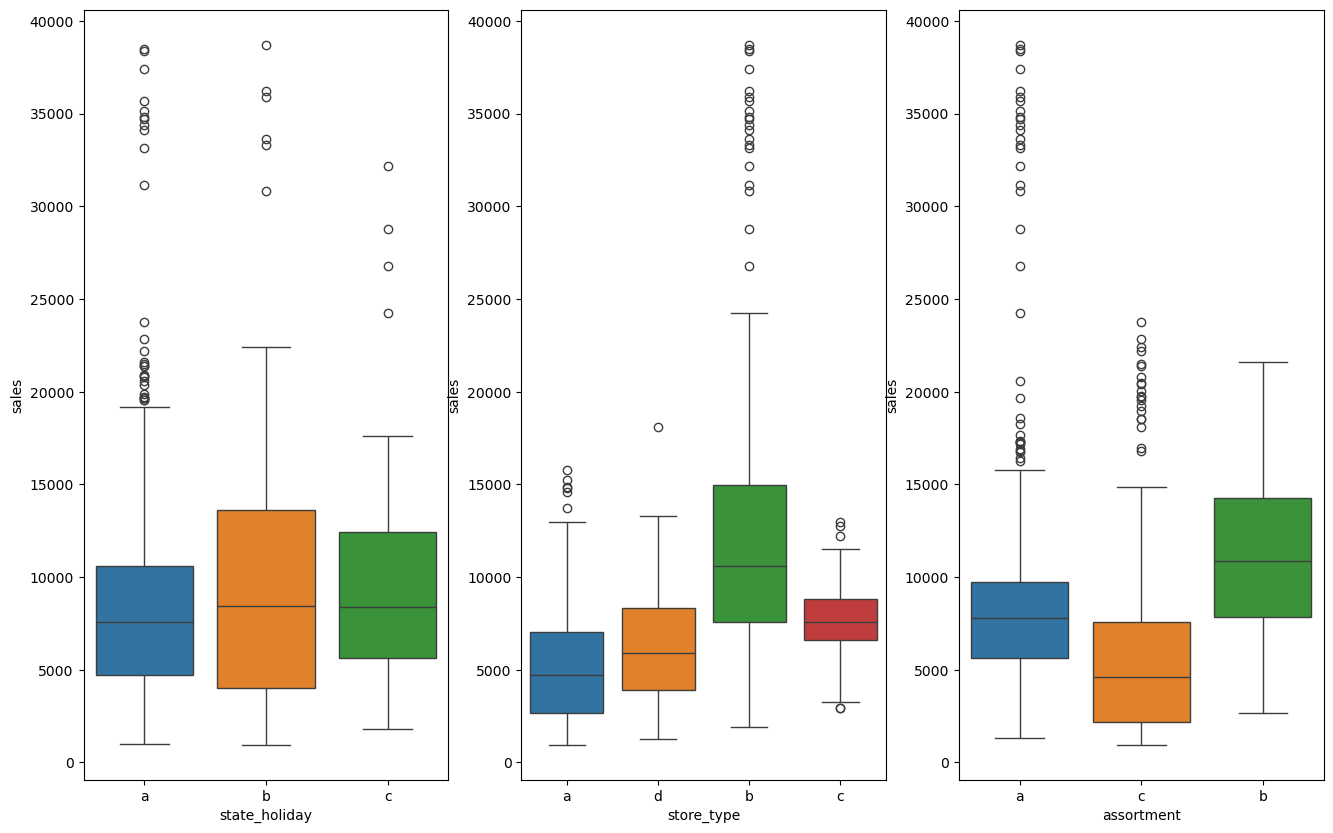

In [780]:
# filter only important dates
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(16,10))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1, hue = 'state_holiday')

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1, hue = 'store_type')

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1, hue = 'assortment')

### Hypothesis List
Hypotheses that can be answered based on the available data set. In a real environment, the missing information would be requested from the data engineering team to provide some important variables to answer the other hypotheses.

1. Stores with a larger product assortment should sell more.

2. Stores with closer competitors should sell less.

3. Stores with competitors that have been around for longer should sell more.

4. Stores with promotions running for longer should sell more.

5. Stores with more days of promotions should sell more.

6. Stores with more consecutive promotions should sell more.

7. Stores that open during the Christmas holidays should sell more.

8. Stores should sell less on weekends.

9. Stores should sell more over the years.

10. Stores should sell more in the second half of the year.

11. Stores should sell more after the 10th of each month.

12. Stores should sell less during school holidays.

### Feature Engineering

In [787]:
df2 = df1.copy()

In [789]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since - create one column which has both year and month and day as 1
# competition time month - difference in months between competition since and actual date of sale
df2['competition_since'] = df2.apply(lambda x: datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since - convert week and year into datetime object and then calculate the difference between promo date and actual sales date
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%U-%u')- timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x : x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday, a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas_holiday' if x == 'c' else 'regular_day')


# Filtering Variables

In [791]:
df3 = df2.copy()

### Filtering Rows

In [794]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### Columns Selection

In [797]:
cols_drop = ['customers','open', 'promo_interval','month_map']
df3 = df3.drop( cols_drop, axis=1)

# Exploratory Data Analysis

In [800]:
df4 = df3.copy()

### Univariate Analysis

<Axes: xlabel='sales', ylabel='Count'>

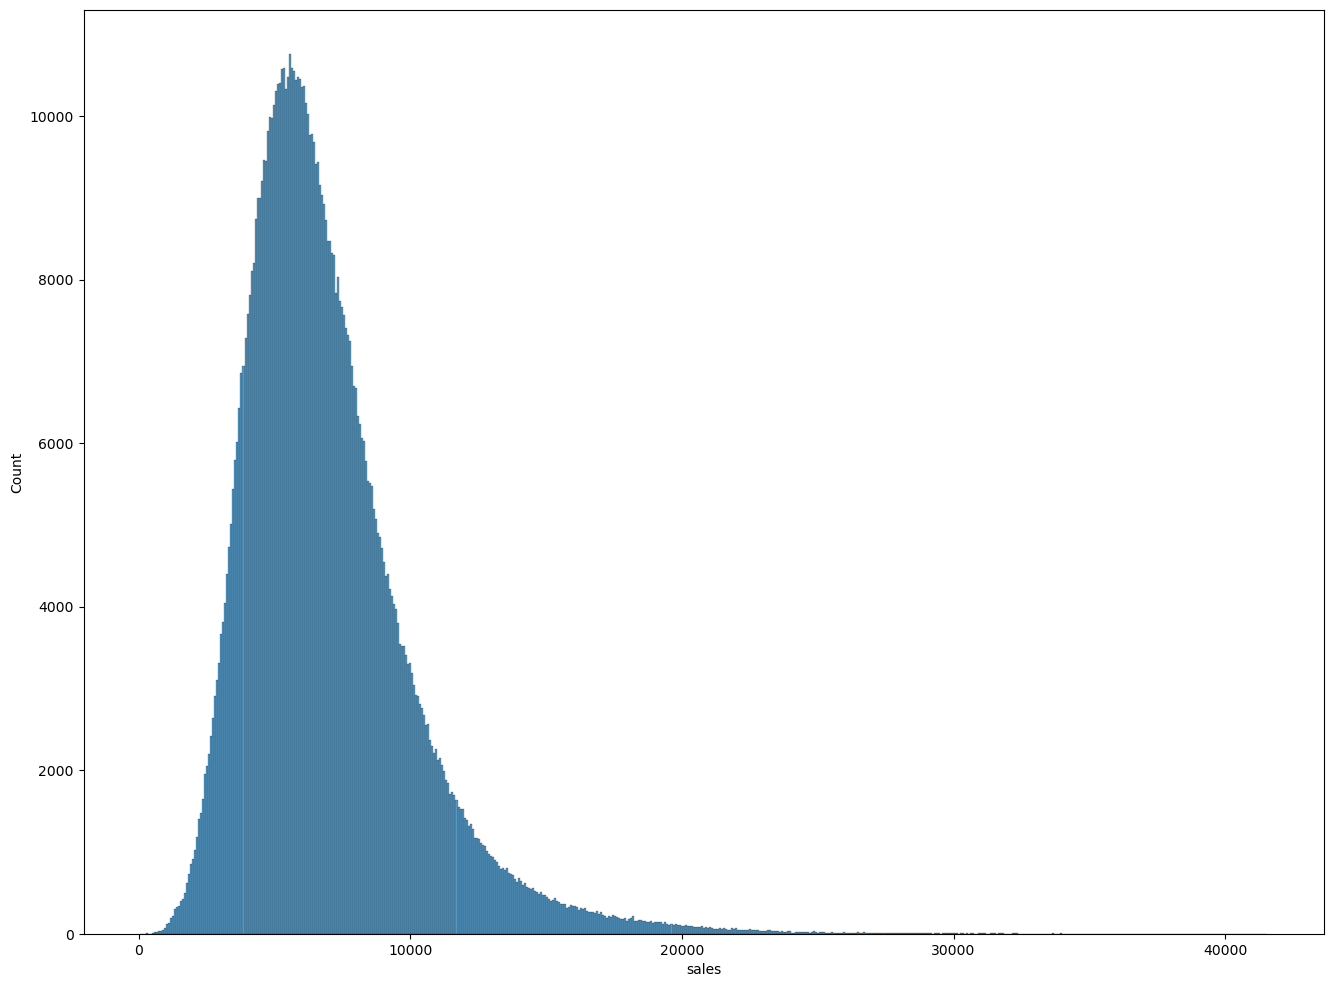

In [803]:
plt.rcParams['figure.figsize'] = [16, 12]
sns.histplot(df4['sales'])

### Numerical Variable

Analyzing the graph below of the numerical variables, it can be seen that the day_of_week feature has no variations, that is, the stores sold basically the same amount during each day of the week, therefore, this feature will not be relevant to the model. Other features presented important information for the business, such as is_promo, in which it can be seen that there were more sales of products that were not on sale, which can be an insight for the business team.

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

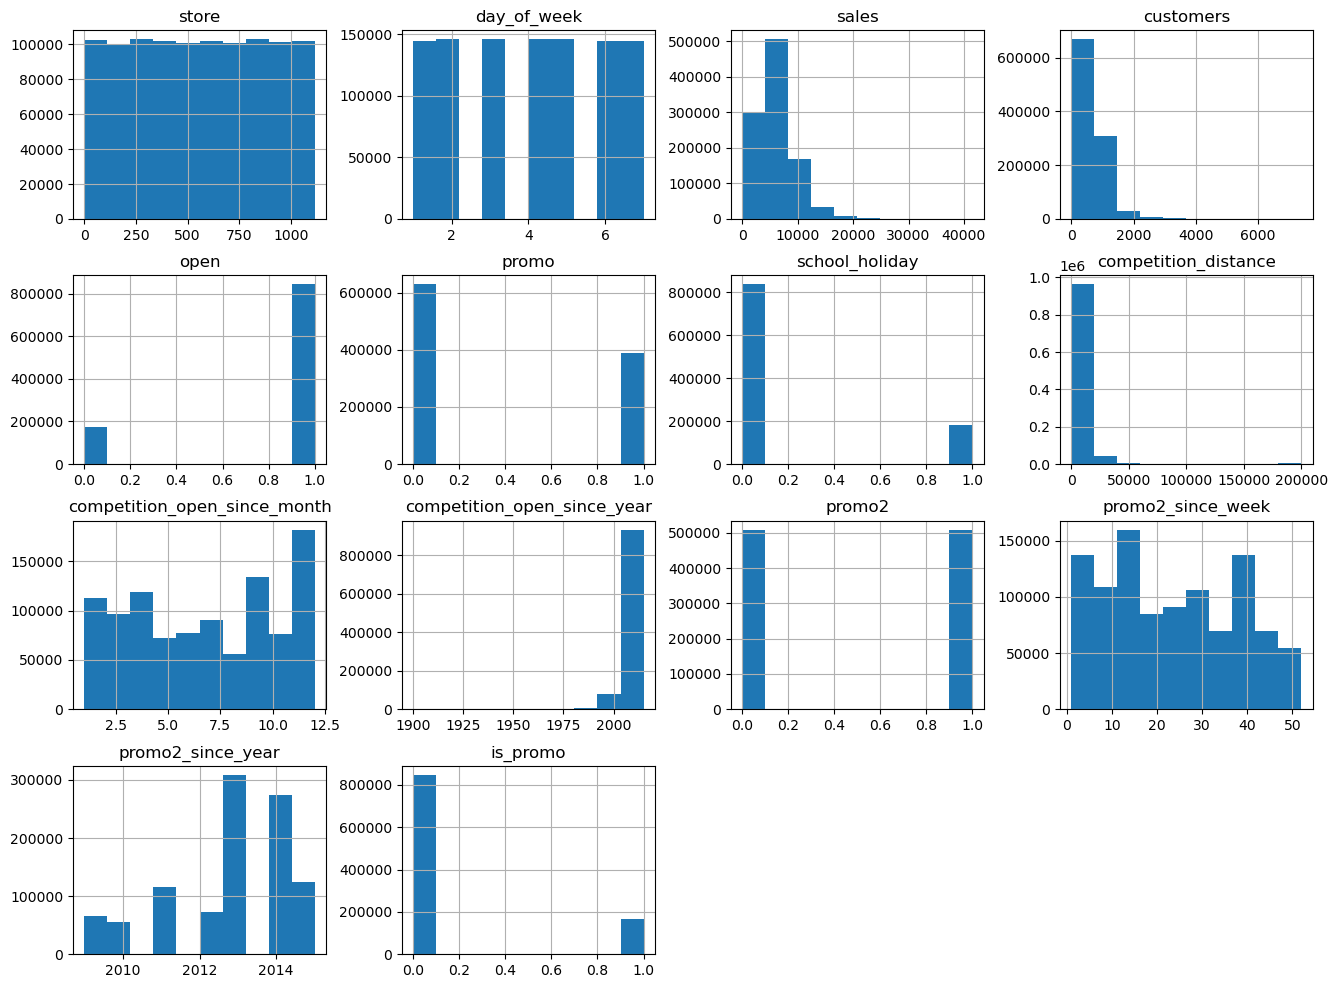

In [807]:
num_attributes.hist()

### Categorical Variable

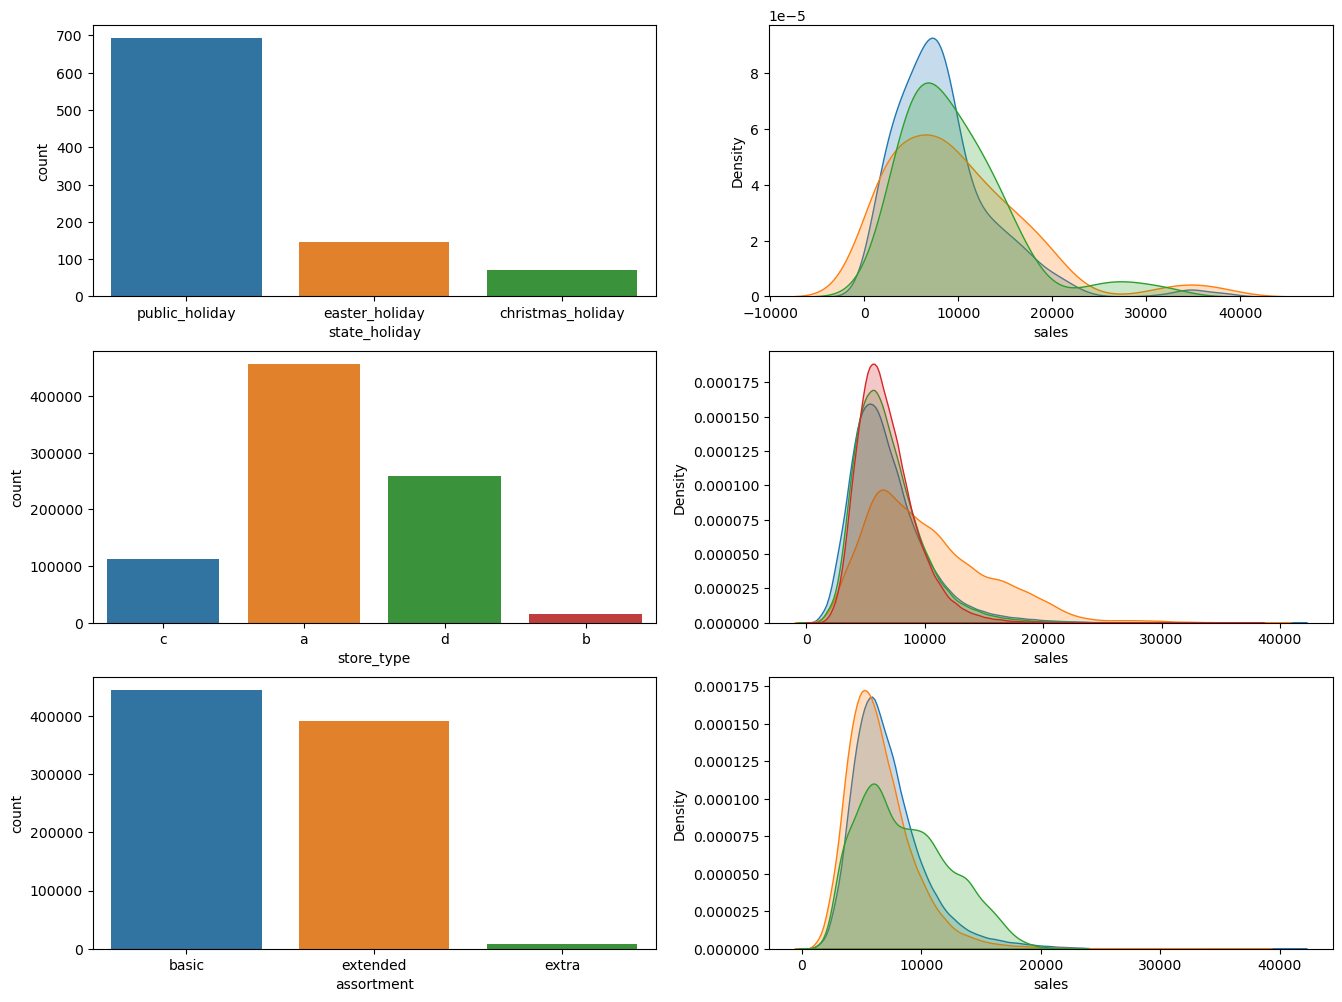

In [810]:
# state holiday
aux1 = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3,2,1)
sns.countplot( x = aux1['state_holiday'], hue = aux1['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot( data=df4[df4['state_holiday'] == 'public_holiday']['sales'], fill=True)
sns.kdeplot( data=df4[df4['state_holiday'] == 'easter_holiday']['sales'], fill=True)
sns.kdeplot( data=df4[df4['state_holiday'] == 'christmas_holiday']['sales'], fill=True)

# store_type
plt.subplot(3,2,3)
sns.countplot( x = df4['store_type'], hue = df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot( data=df4[df4['store_type'] == 'a']['sales'], fill=True)
sns.kdeplot( data=df4[df4['store_type'] == 'b']['sales'], fill=True)
sns.kdeplot( data=df4[df4['store_type'] == 'c']['sales'], fill=True)
sns.kdeplot( data=df4[df4['store_type'] == 'd']['sales'], fill=True)

# assortment 
plt.subplot(3,2,5)
sns.countplot( x = df4['assortment'], hue = df4['assortment'])

plt.subplot( 3, 2, 6 )
sns.kdeplot( data=df4[df4['assortment'] == 'extended']['sales'], fill=True );
sns.kdeplot( data=df4[df4['assortment'] == 'basic']['sales'], fill=True );
sns.kdeplot( data=df4[df4['assortment'] == 'extra']['sales'], fill=True );


## Bivariate Analysis

### H1: Stores with a larger assortment of products should sell more.

False. According to the graph below, we can see that stores with a larger assortment are the ones that sell less.

<Axes: xlabel='assortment', ylabel='sales'>

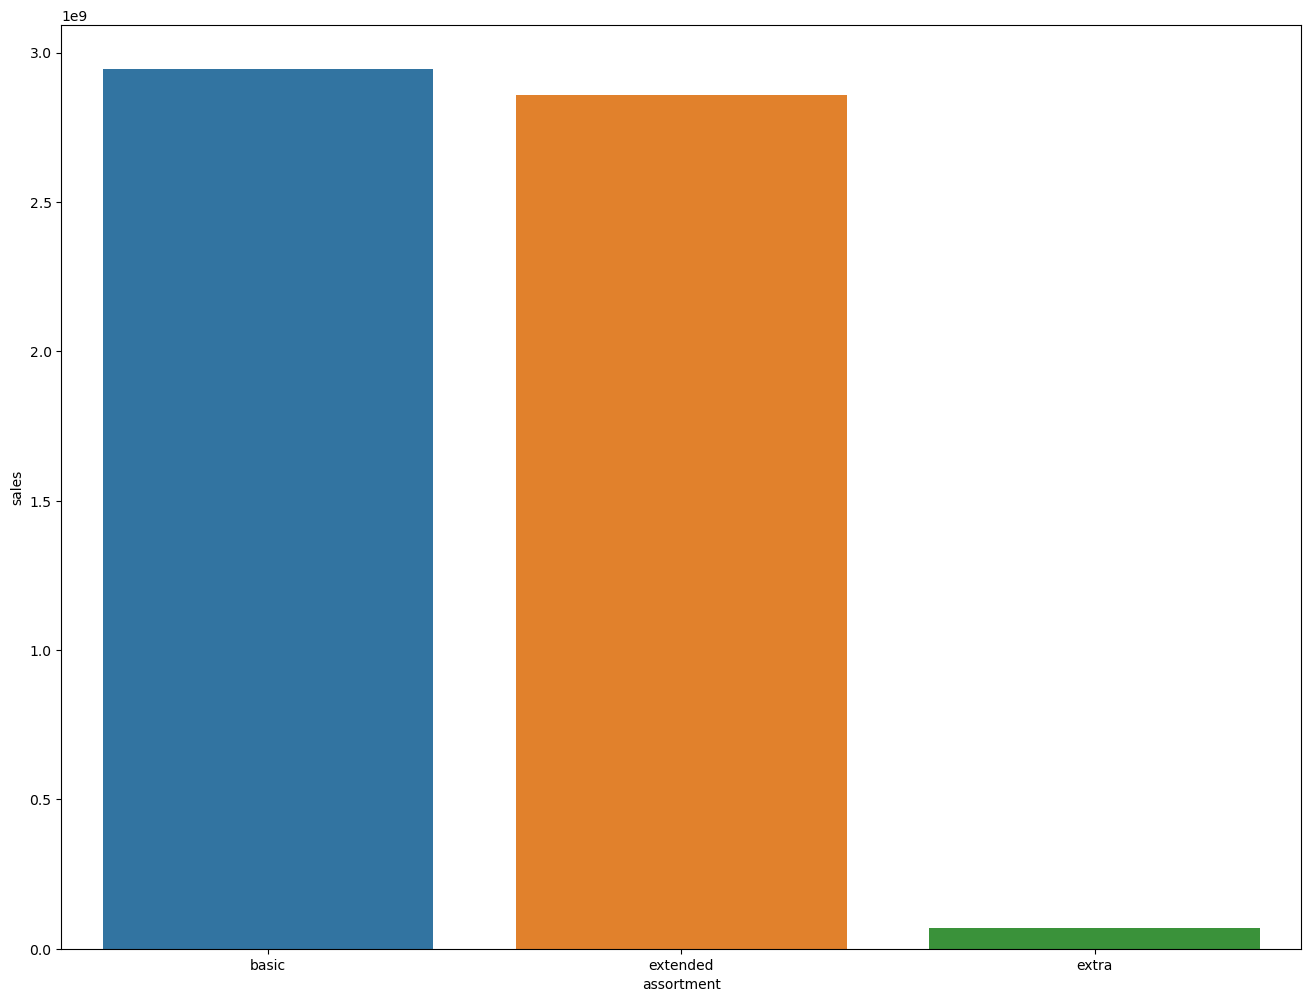

In [813]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, hue='assortment')

To further examine this hypothesis, we first want to find out whether stores with a larger assortment sold more in the past than they do now. However, by analyzing the second time graph, we can see that the extra assortment fluctuated a lot over time, which was not possible to identify in the first graph. Analyzing the first graph, we can see that the basic and extended assortments are very similar, but that by viewing the set of 3 variables, they will be relevant to the model.

<Axes: xlabel='year_week'>

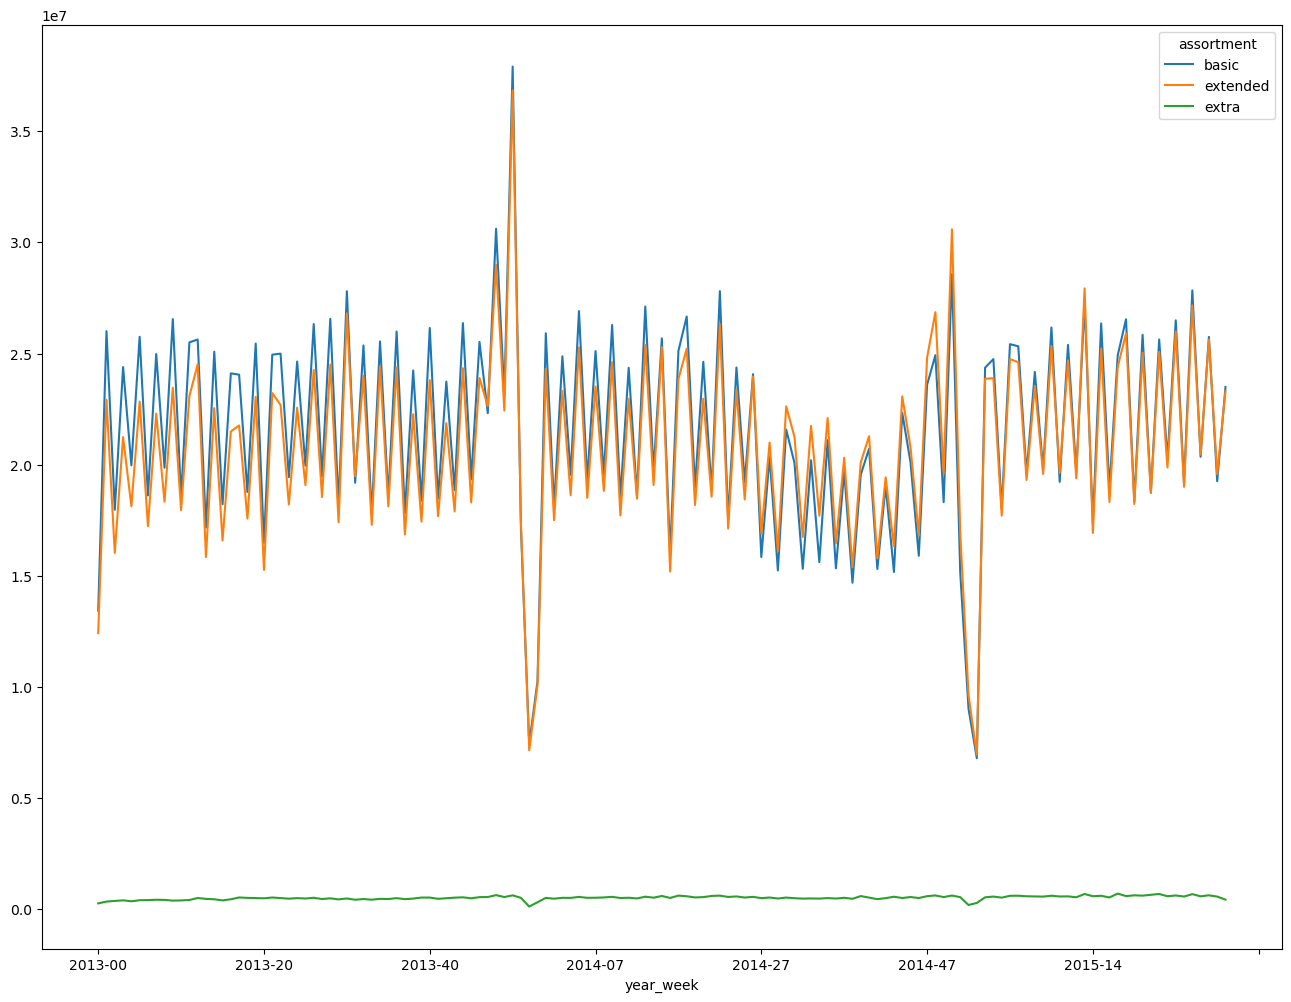

In [816]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

<Axes: xlabel='year_week'>

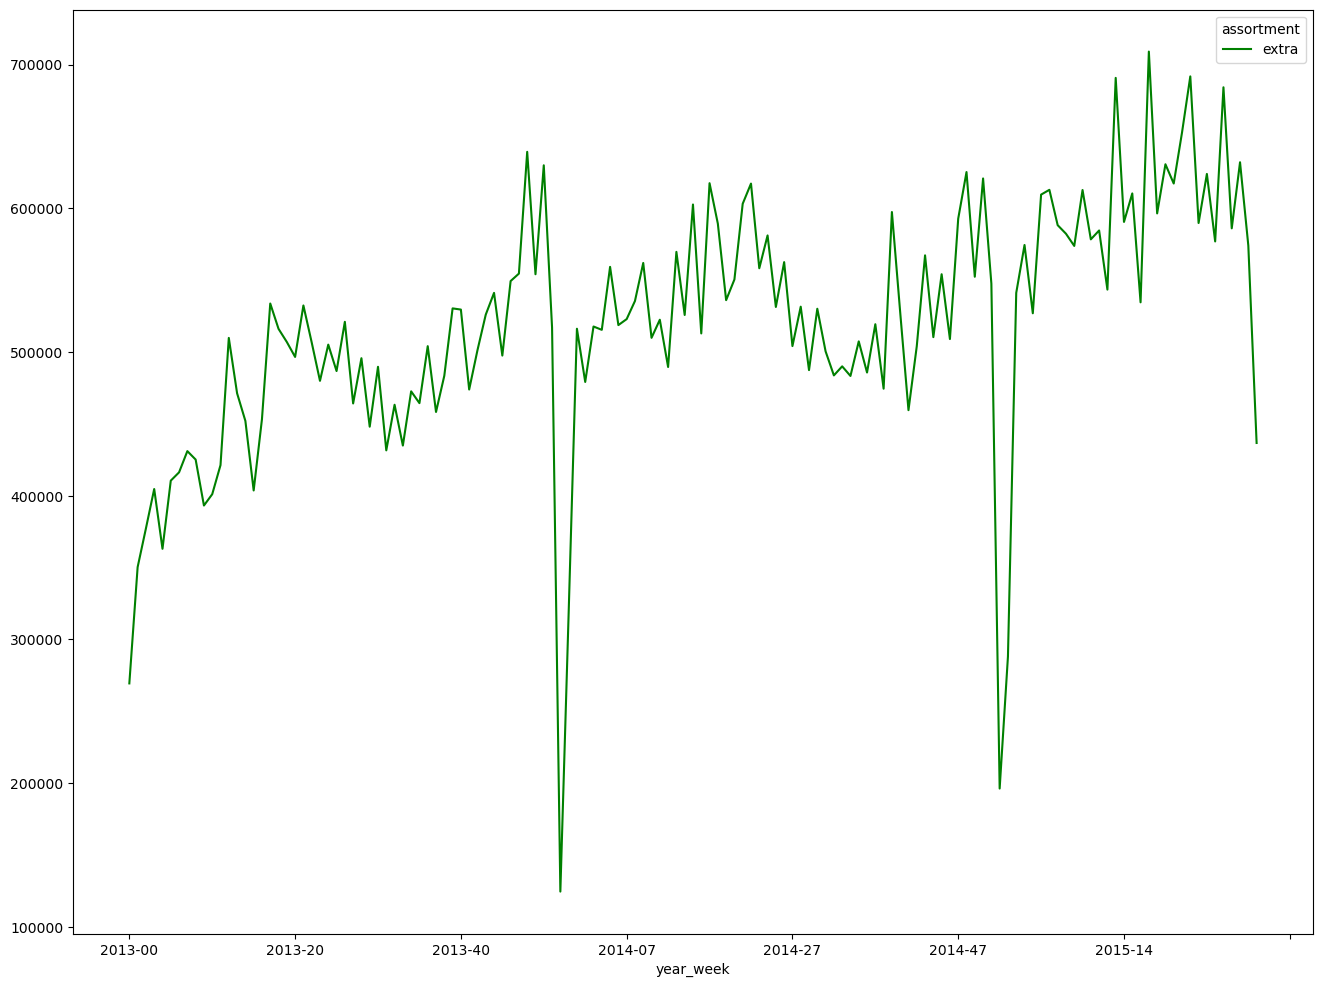

In [818]:
aux3 = df4[df4['assortment'] == 'extra']
aux3 = aux3[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(color='green')

### H2: Stores with closer competitors should sell less.

False. Analyzing the graphs below, we can see that stores with close competitors sell more than stores with more distant competitors. This is really intriguing, and goes against the common belief that "the greater the competition, the lower the sales". This is very likely to be a relevant insight for the business.

<Axes: xlabel='competition_distance_binned', ylabel='sales'>

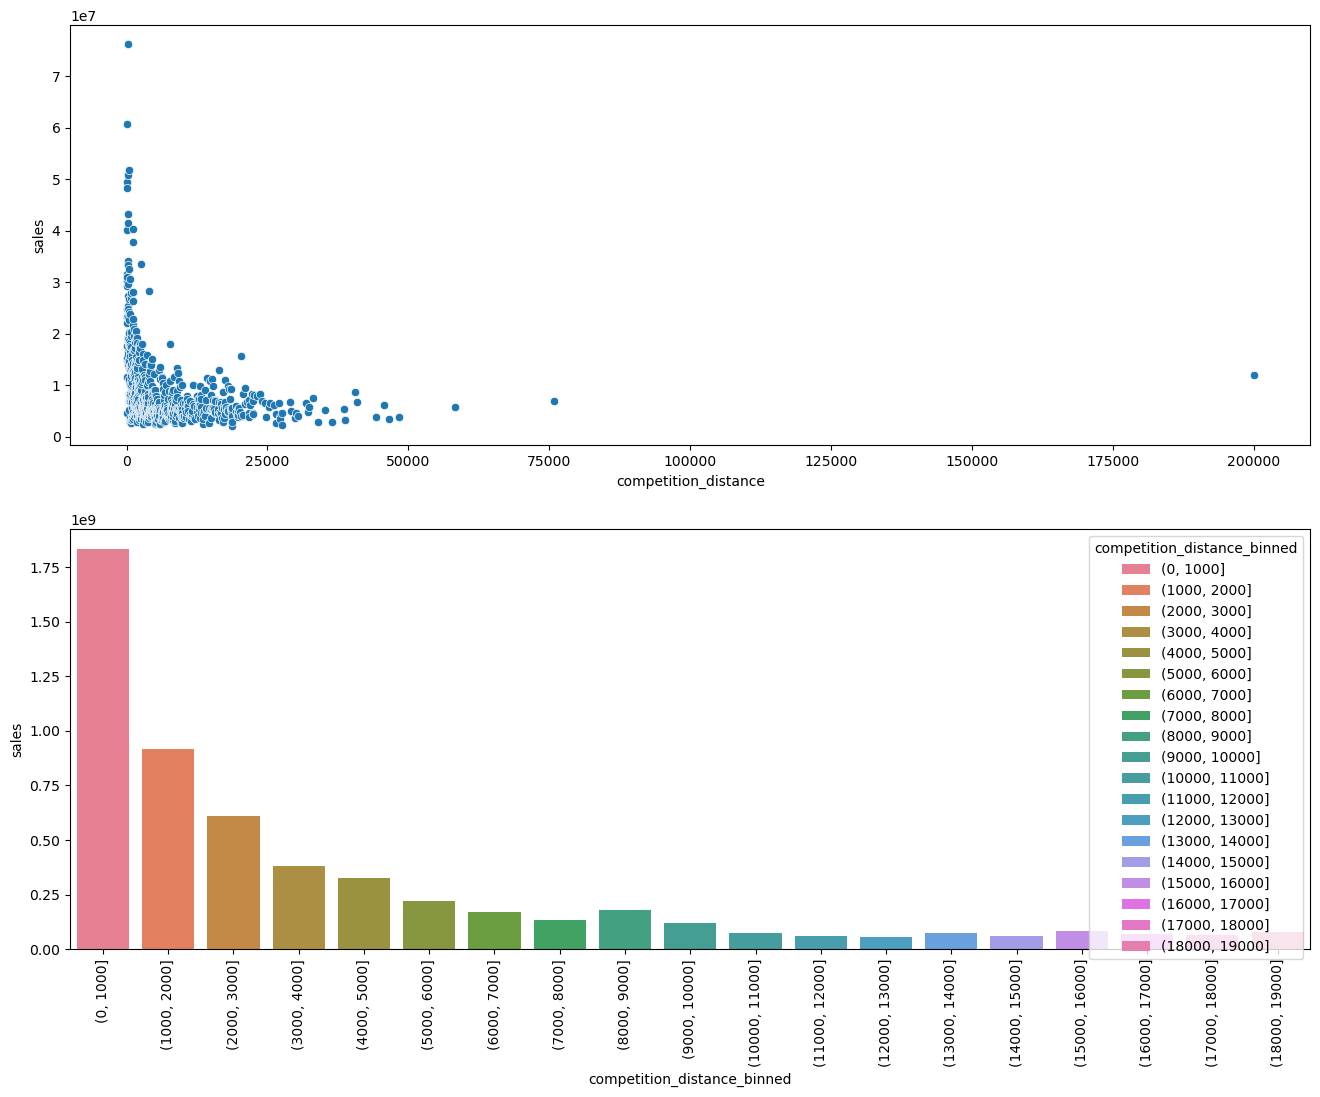

In [821]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

#agroup competition distance
bins = list( np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned', observed=True).sum().reset_index()

# scatter plot
plt.subplot(2,1,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(2,1,2)
plt.xticks(rotation=90)
sns.barplot( x='competition_distance_binned', y='sales', data=aux2, hue='competition_distance_binned')


To infer the correlation of the feature with the response variable, a heatmap was used. In it, it can be seen that this variable alone has a certain correlation with sales.

<Axes: >

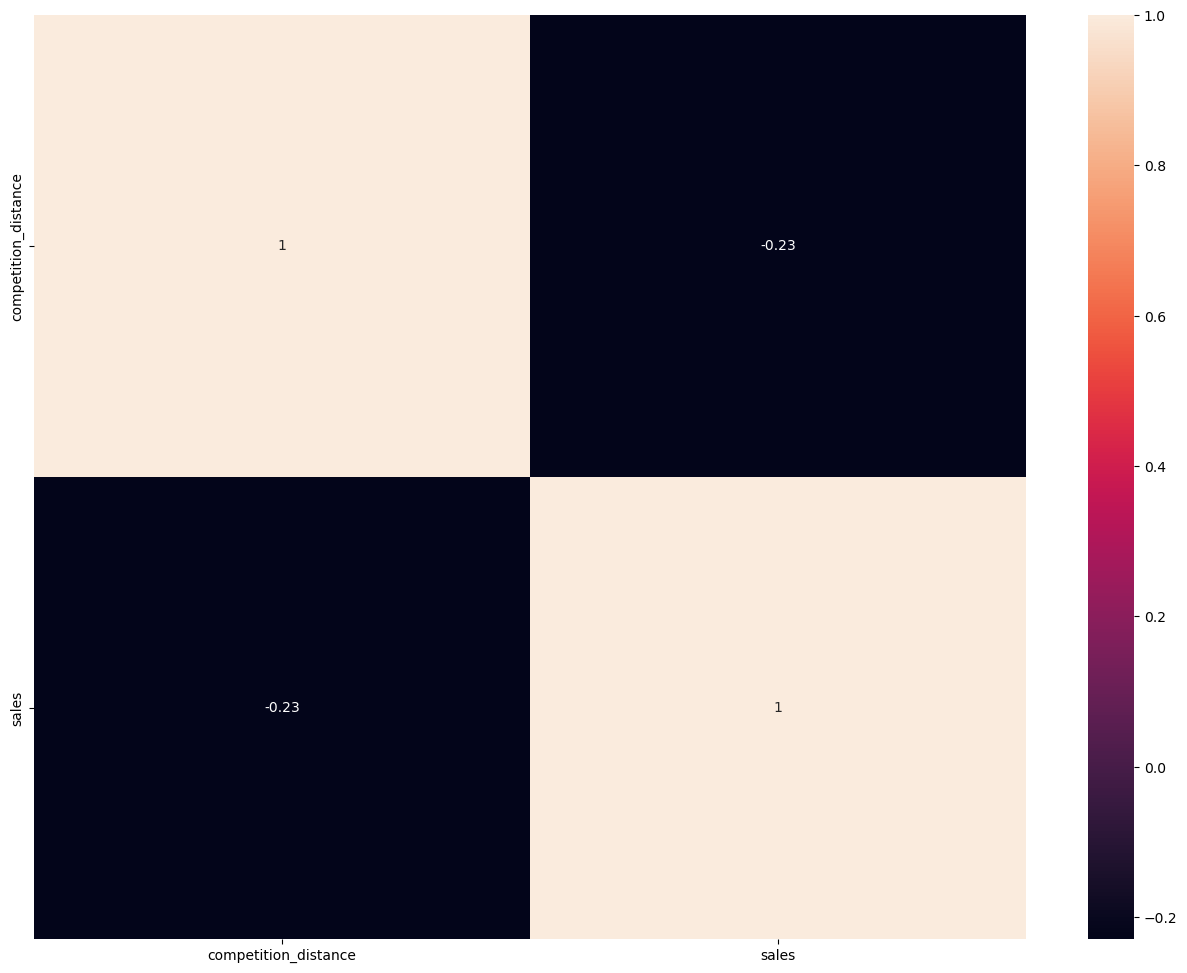

In [824]:
sns.heatmap( aux1[['competition_distance','sales']].corr(method = 'pearson'), annot=True)

### H3: Stores with competitors that have been around for a longer time should sell more.

False. Analyzing the graph below, we can see that the more recent the competition, the higher the number of sales, which is also quite intriguing. Therefore, stores with competitors that have been around for a longer time sell less.

<Axes: xlabel='competition_time_month', ylabel='sales'>

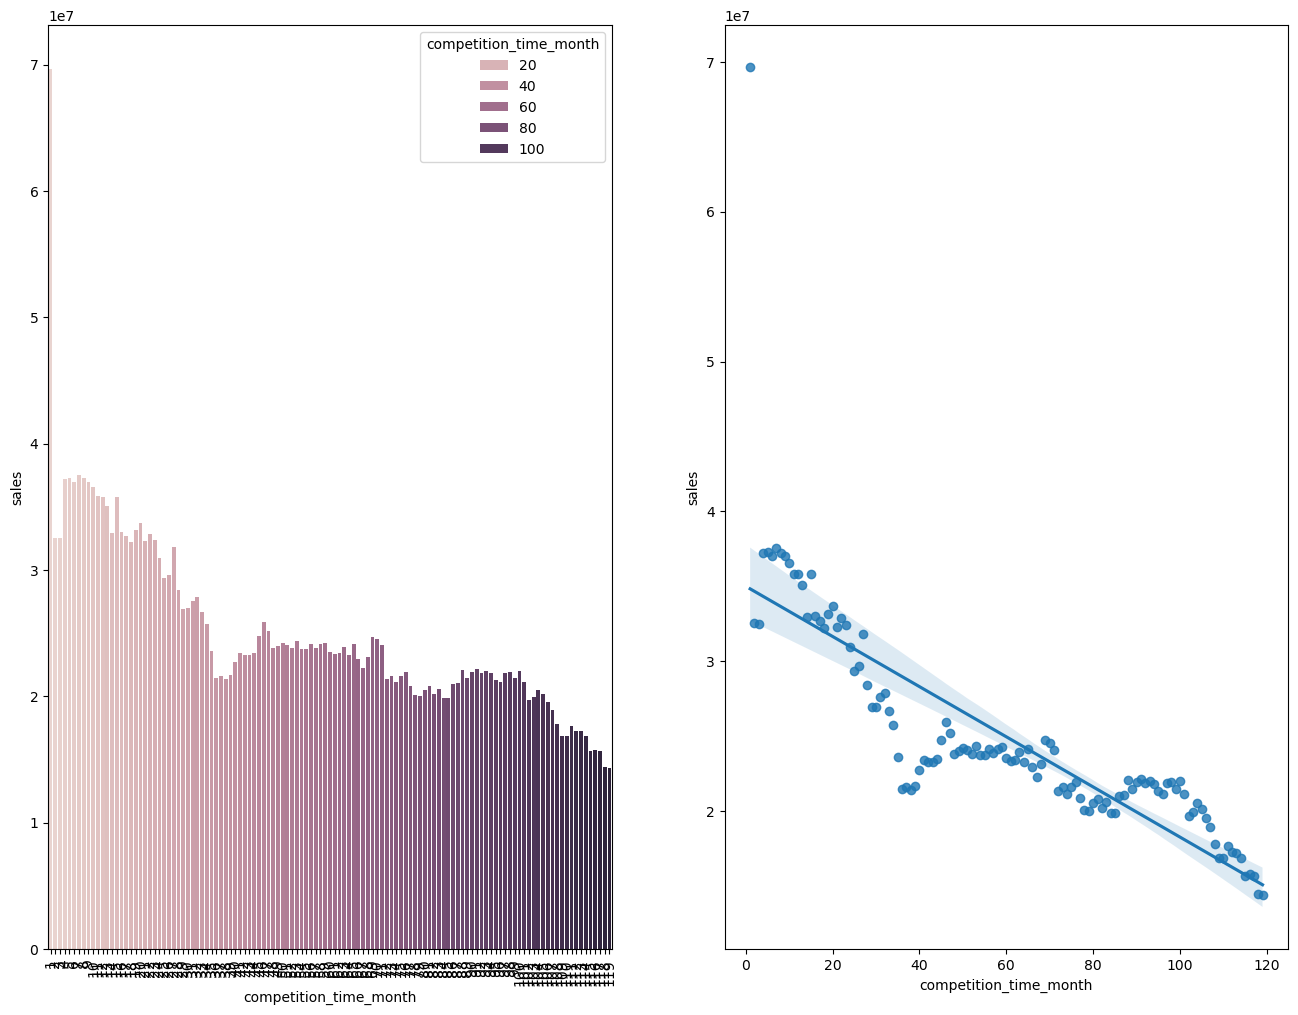

In [829]:
plt.subplot( 1 ,2, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & ( aux1['competition_time_month'] > 0 )]

plt.xticks(rotation=90)
sns.barplot( x='competition_time_month', y='sales', data=aux2, hue='competition_time_month')

plt.subplot( 1, 2, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 )

To infer the correlation of the feature with the response variable, a heatmap was used. In it, it can be seen that this variable alone has a weak correlation with sales.

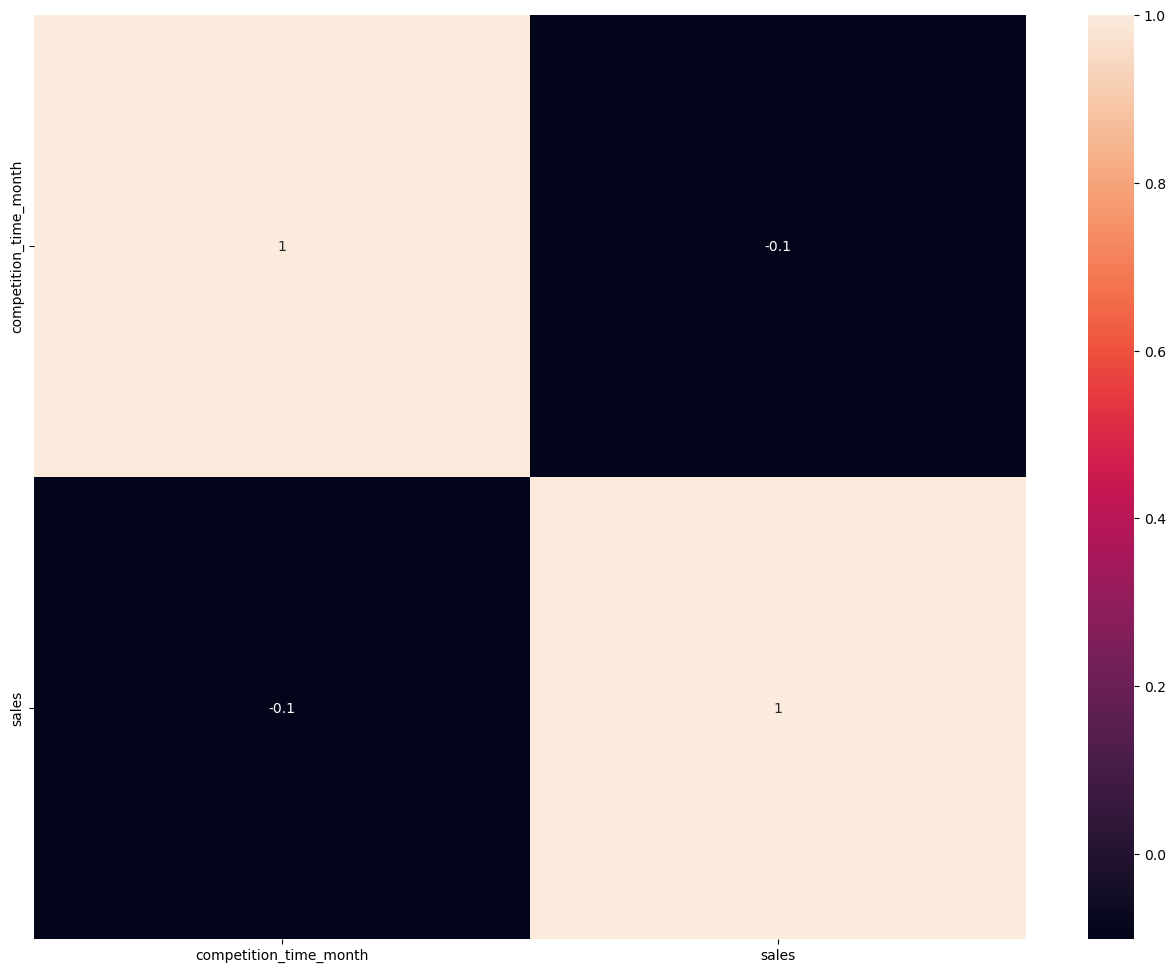

In [832]:
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H4: Stores with promotions running for longer should sell more.

False. Analyzing the graphs below, we can see that for values ​​where the promo_time_week value is positive, it means that sales were made during the extended promotion period, and if it is negative, it means that sales were made during the regular promotion period. Therefore, analyzing the first graph, we can see that promotions running for longer sell regularly, and not only that, as time goes by, they have a tendency to decline, which can be seen in the trend graph on the side, meaning that the effect of the promotion has a certain period of effectiveness.

Sales during the regular period tend to grow over time, this may be the result of the work of the marketing department, in which people are informed that the store is in a promotional period, resulting in more sales.

<Axes: xlabel='promo_time_week', ylabel='sales'>

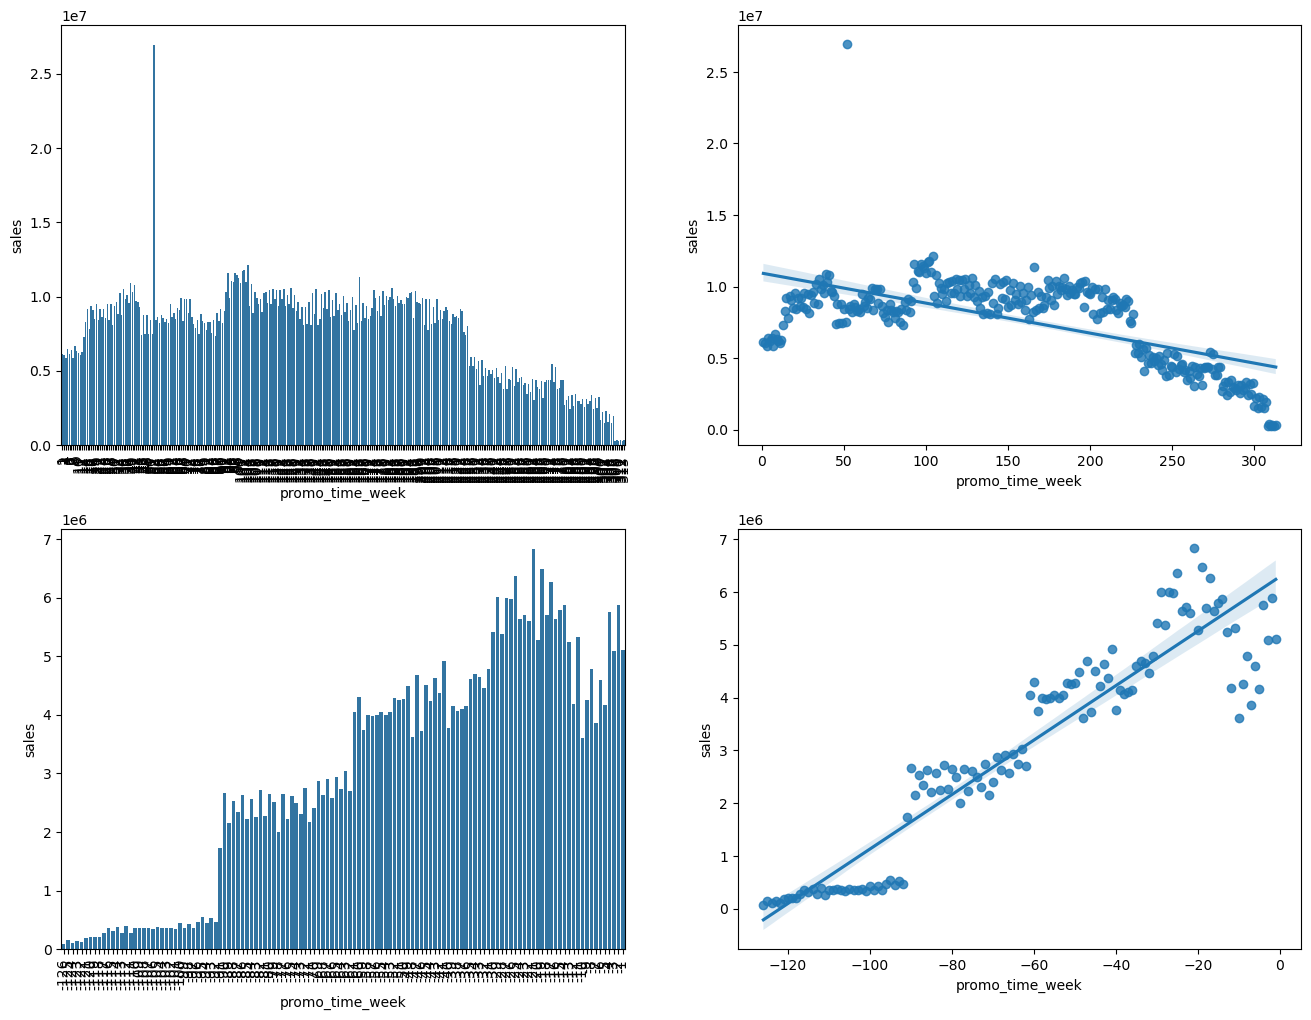

In [840]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

# extended promo
plt.subplot(2, 2, 1)
plt.xticks( rotation=90 )
aux2 = aux1[aux1['promo_time_week'] > 0 ]
sns.barplot( x='promo_time_week', y='sales', data=aux2 )

plt.subplot(2, 2, 2)
sns.regplot( x='promo_time_week', y='sales', data=aux2 )

# regular promo
plt.subplot(2, 2, 3)
plt.xticks( rotation=90 )
aux3 = aux1[aux1['promo_time_week'] < 0 ]
sns.barplot( x='promo_time_week', y='sales', data=aux3)

plt.subplot(2, 2, 4)
sns.regplot( x='promo_time_week', y='sales', data=aux3 )

To infer the correlation of the feature with the response variable, a heatmap was used. In it, it can be seen that this variable alone has a weak correlation with sales.

<Axes: >

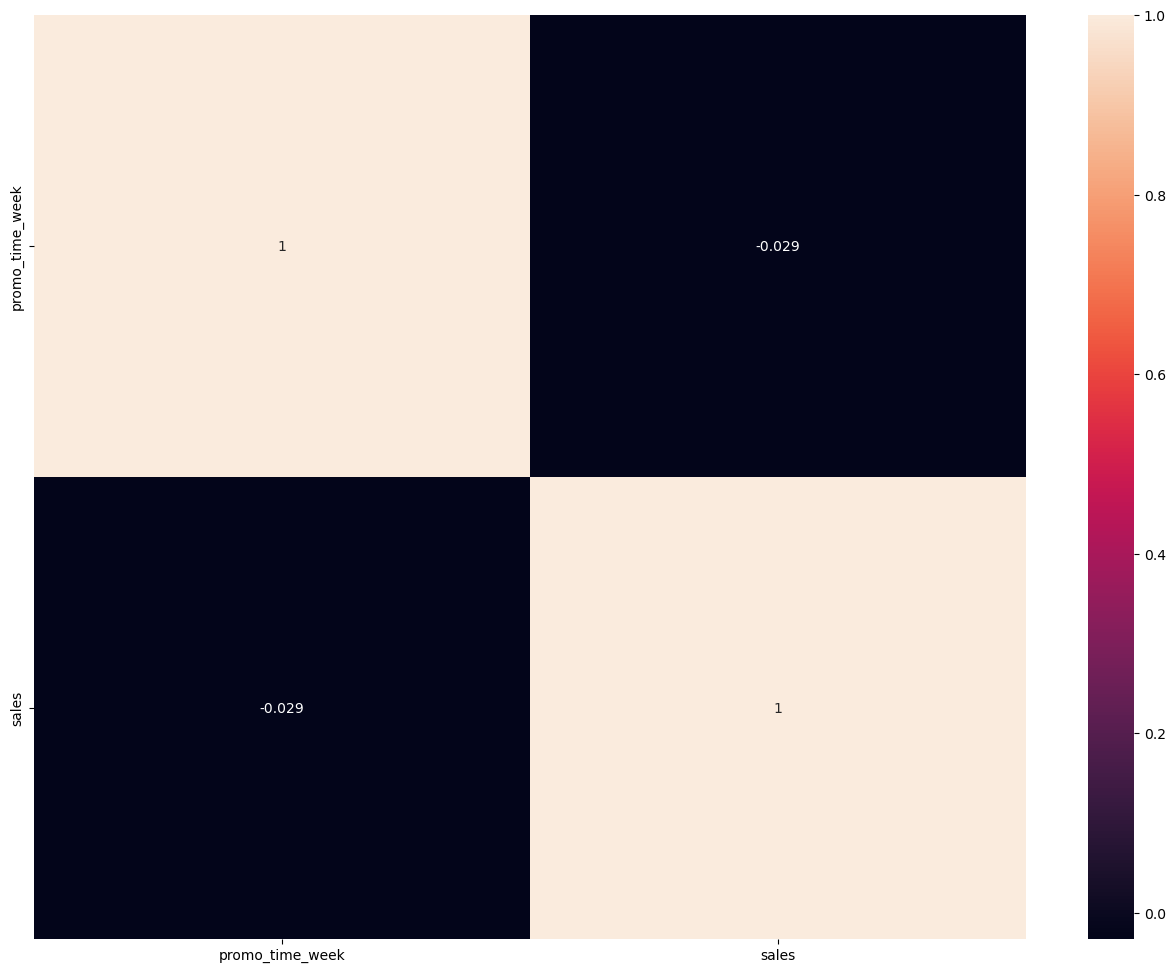

In [843]:
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### H5: Stores with more promotional days should sell more. 

False. Analyzing the graphs below, we can see that for values ​​where the promo_days value is positive, it means that sales were made during the extended promotion period, and if it is negative, it means that sales were made during the regular promotion period. Therefore, analyzing the first graph, we can see that promotions running for longer sell regularly, and not only that, as time goes by, they have a tendency to decline, which can be seen in the trend graph on the side, meaning that the effect of the promotion has a certain period of effectiveness.

Sales during the regular period tend to grow over time, this may be the result of the work of the marketing department, in which people are informed that the store is in a promotional period, resulting in more sales.

In [847]:
df4['promo_days'] = df4['promo_time_week'] * 7

<Axes: xlabel='promo_days', ylabel='sales'>

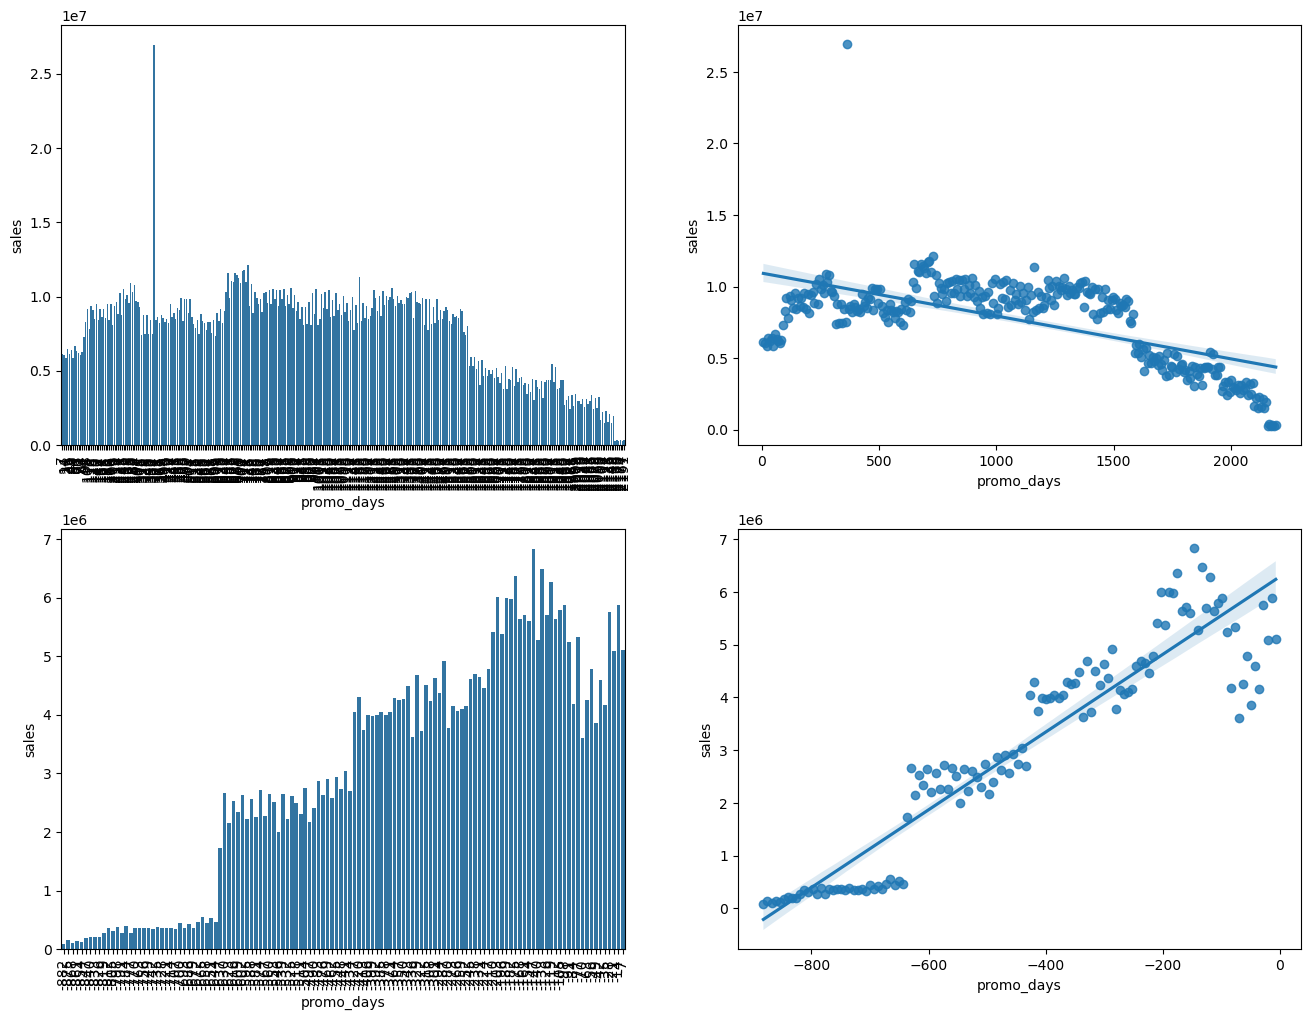

In [857]:
aux1 = df4[['promo_days','sales']].groupby('promo_days').sum().reset_index()

# extended promo
plt.subplot(2, 2, 1)
plt.xticks( rotation=90 )
aux2 = aux1[aux1['promo_days'] > 0 ]
sns.barplot( x='promo_days', y='sales', data=aux2 )

plt.subplot(2, 2, 2)
sns.regplot( x='promo_days', y='sales', data=aux2 )

# regular promo
plt.subplot(2, 2, 3)
plt.xticks( rotation=90 )
aux3 = aux1[aux1['promo_days'] < 0 ]
sns.barplot( x='promo_days', y='sales', data=aux3 )

plt.subplot(2, 2, 4)
sns.regplot( x='promo_days', y='sales', data=aux3 )

<Axes: >

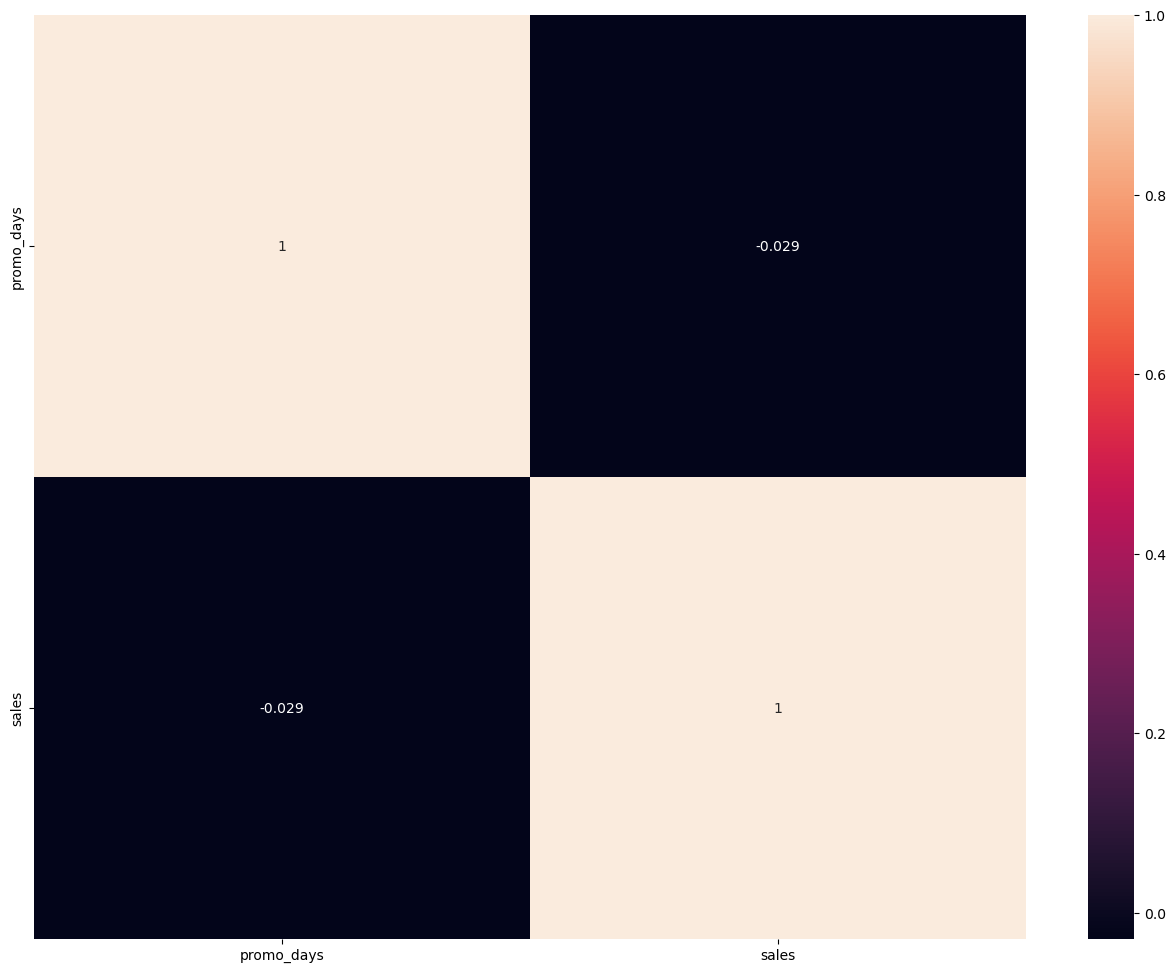

In [859]:
sns.heatmap( aux1.corr( method='pearson'), annot=True )

### H6: Stores with more consecutive promotions should sell more.

False. Analyzing the table below, it can be seen that the stores that participated only in the regular promotion promo sold more than the stores that participated in the extended promotion promo2. An interesting piece of information is that stores that did not participate in any promotion sold more than stores that participated in both promotions simultaneously, in which these stores also had a higher sales frequency.

In [863]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2']).sum().reset_index().sort_values( by='sales' )

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


Text(0.5, 0, 'regular promo')

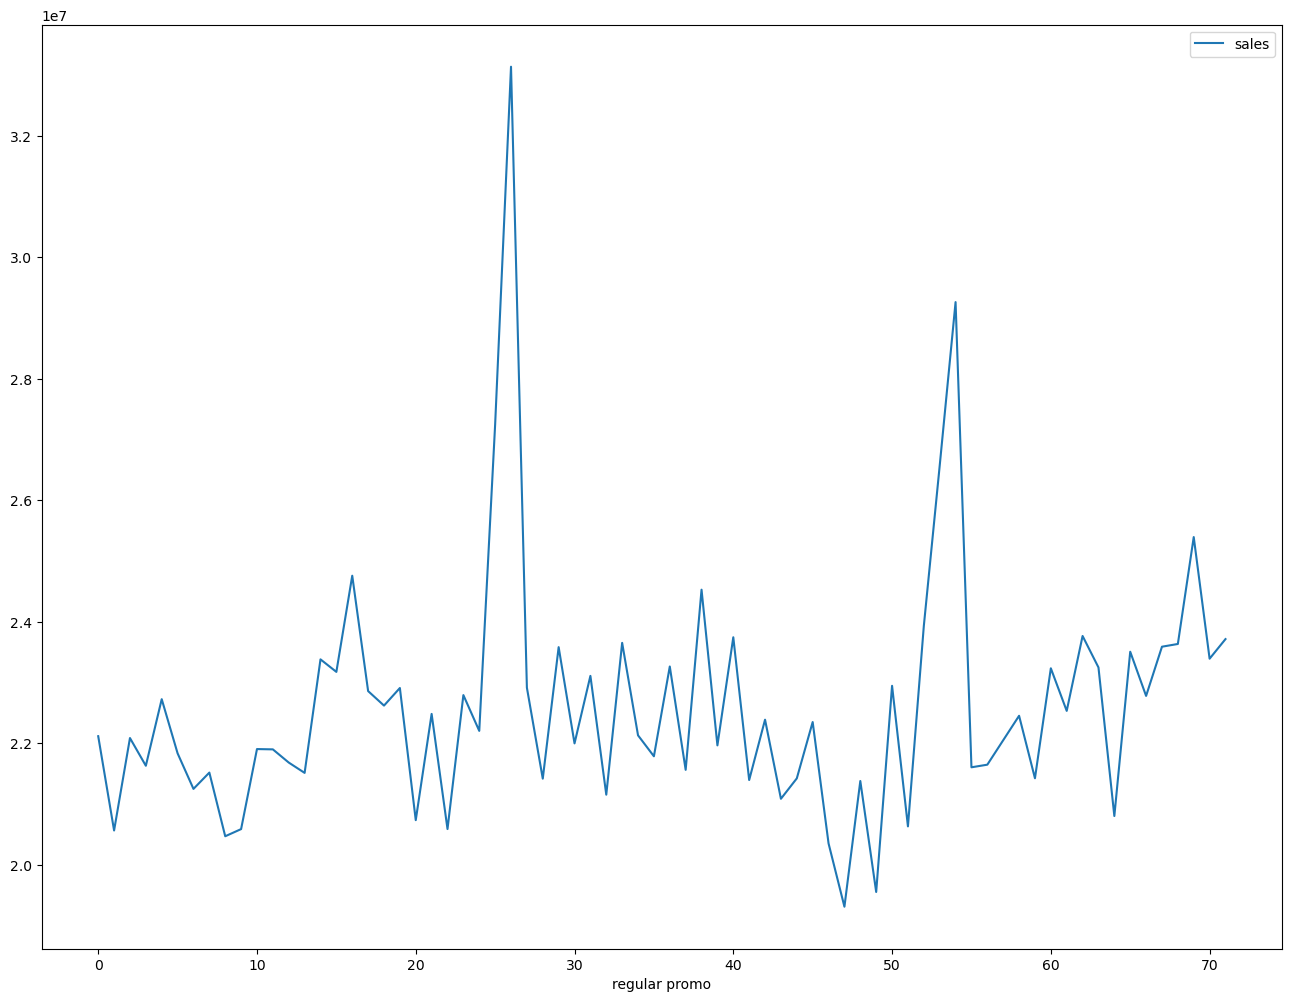

In [873]:
# regular promo
aux1 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux1.plot()
plt.xlabel('regular promo')

Text(0.5, 0, 'without promo')

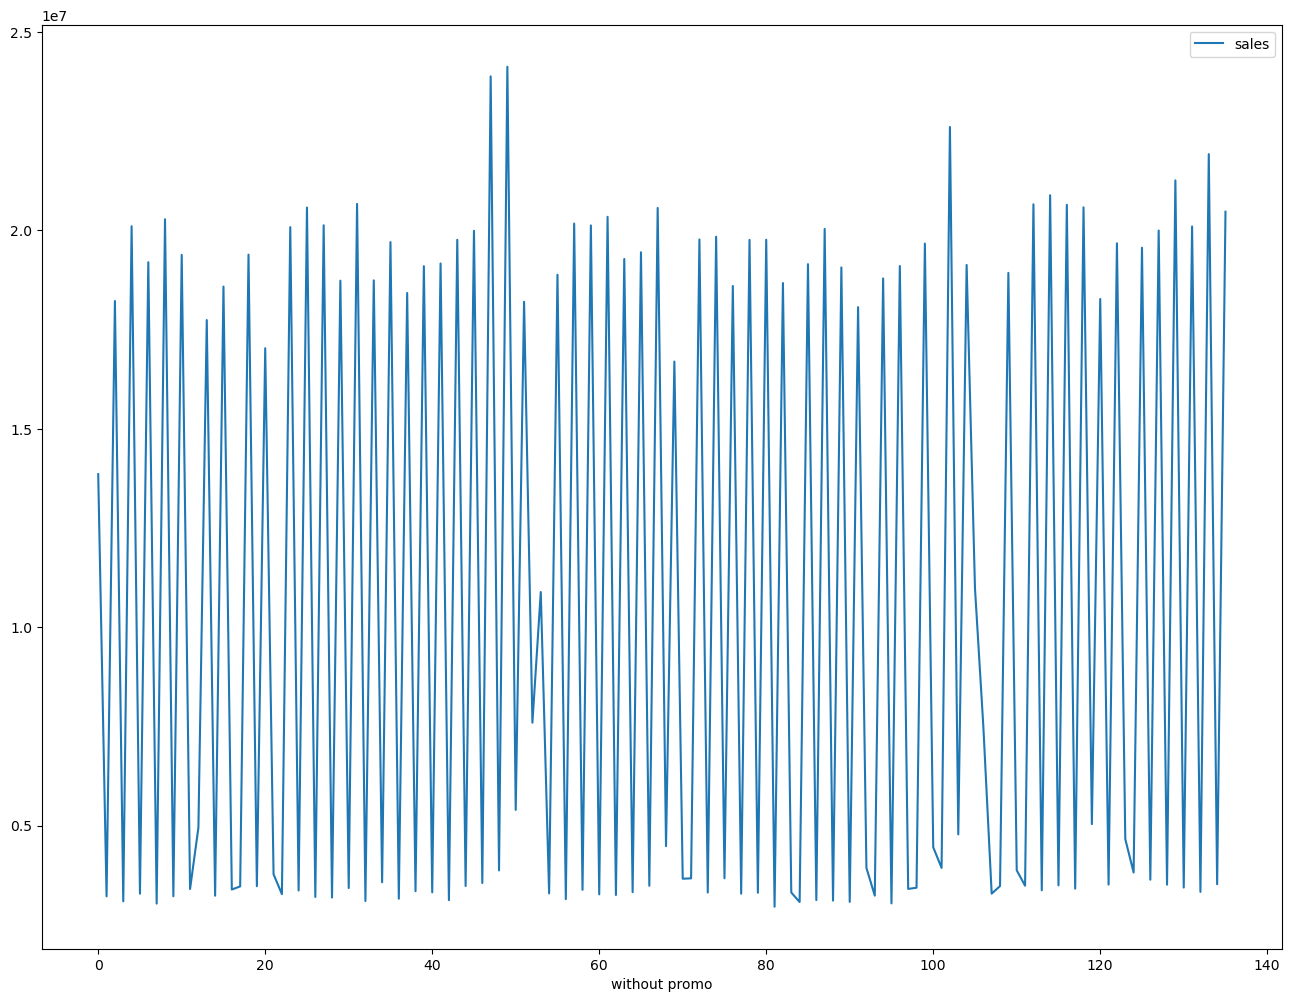

In [875]:
# without promo
aux1 = df4[(df4['promo']==0) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux1.plot()
plt.xlabel('without promo')

### H7: Stores that open during the Christmas holidays should sell more.

False.. Analyzing the graphs below, it is possible to notice that stores open during the Christmas holidays sell less. Sales are concentrated on public holidays, and not on special dates such as Christmas and Easter.

<Axes: xlabel='year', ylabel='sales'>

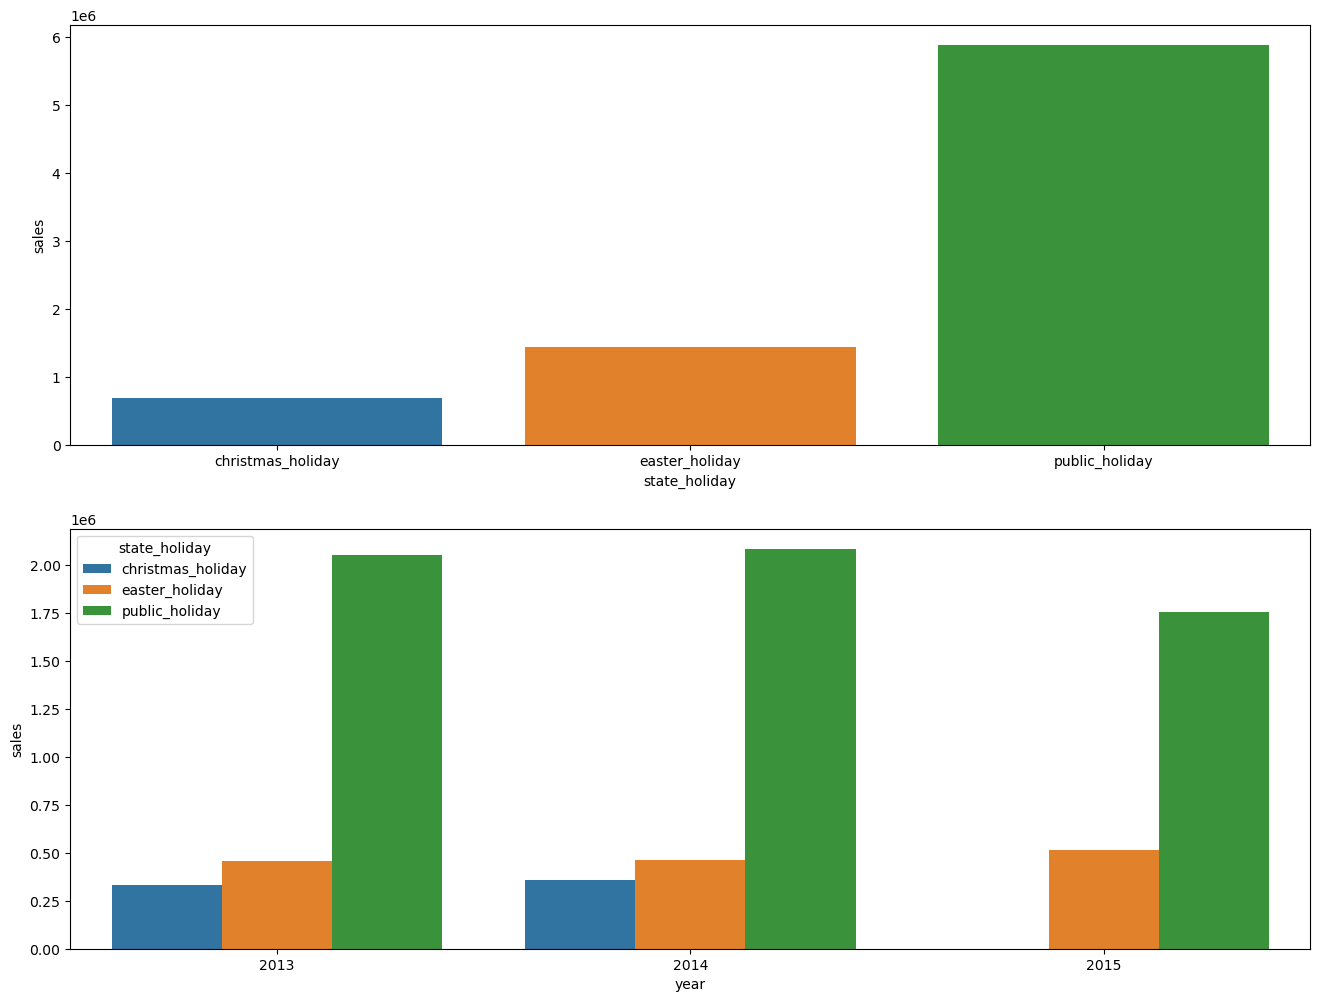

In [880]:
aux1 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(2,1,1)
aux2 = aux1[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux2, hue='state_holiday')

plt.subplot(2,1,2)
aux3=aux1[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux3)

### H8: Stores should sell less on weekends.

True. Analyzing the graphs below, we can see that sales volume is higher during the weekdays. Therefore, on the 6th (Saturday) and 7th (Sunday) are the days when stores sell less.

<Axes: >

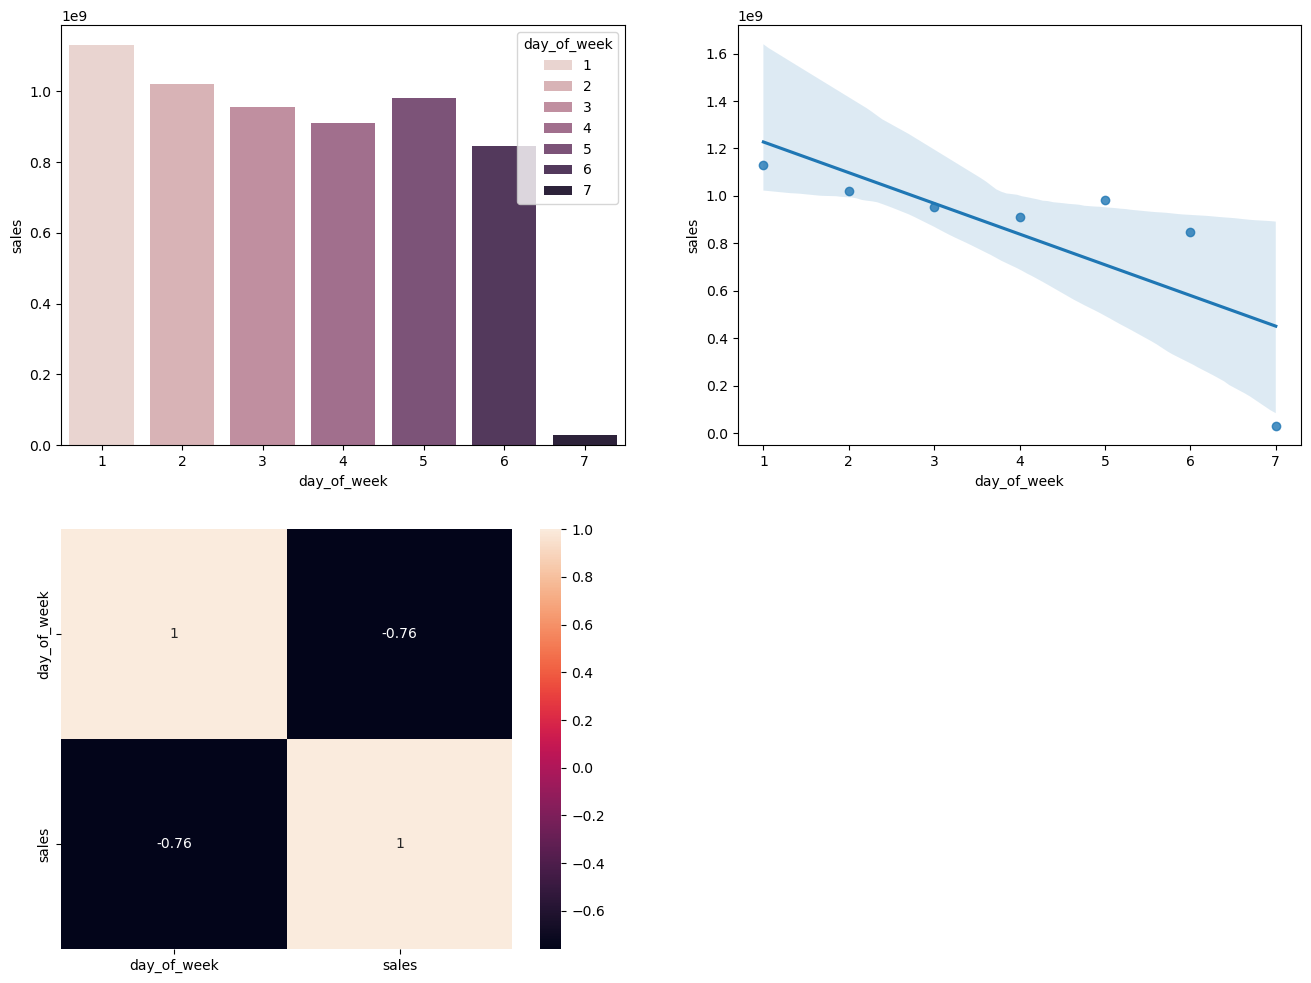

In [885]:

aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1, hue='day_of_week' )

plt.subplot( 2, 2, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 2, 2, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### H9: Stores should sell more over the years.

False. Analyzing the graphs, it is clear that over the years, sales have been declining, not increasing. Therefore, stores sell less over the years.

([<matplotlib.axis.XTick at 0x154363890>,
 [Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016')])

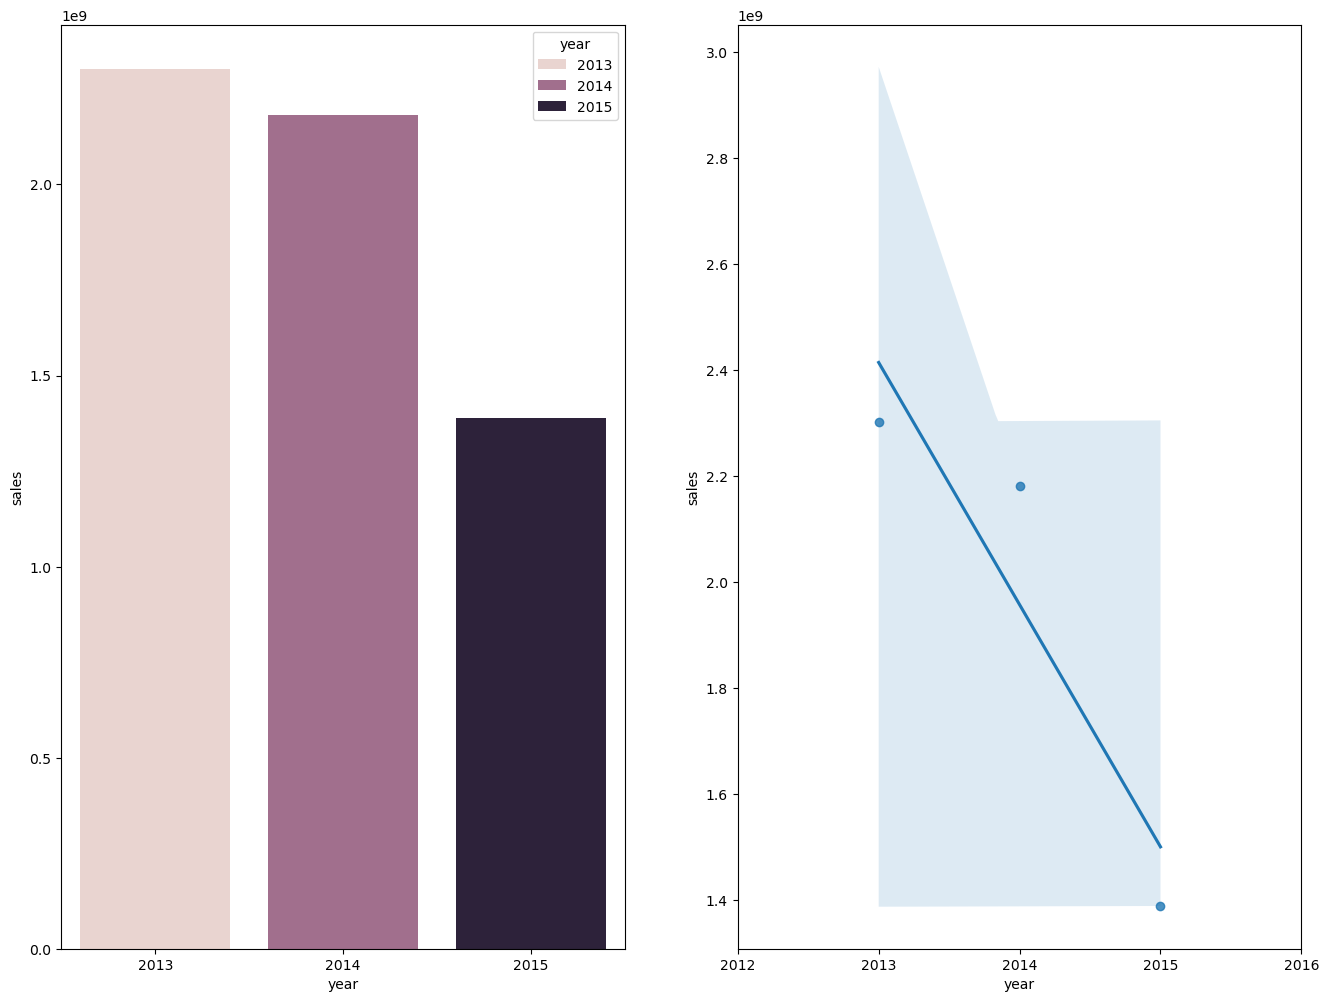

In [892]:

aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 2, 1)
sns.barplot( x='year', y='sales', data=aux1, hue='year' )

plt.subplot( 1, 2, 2)
sns.regplot( x='year', y='sales', data=aux1 )
plt.xticks([2012, 2013, 2014, 2015, 2016])

To infer the correlation of the feature with the response variable, a heatmap was used. In it, it can be seen that this variable alone has a very strong negative correlation with sales. In other words, as the years go by, sales go down. However, this is because this database does not have the complete data from 2015, which was still in progress.

<Axes: >

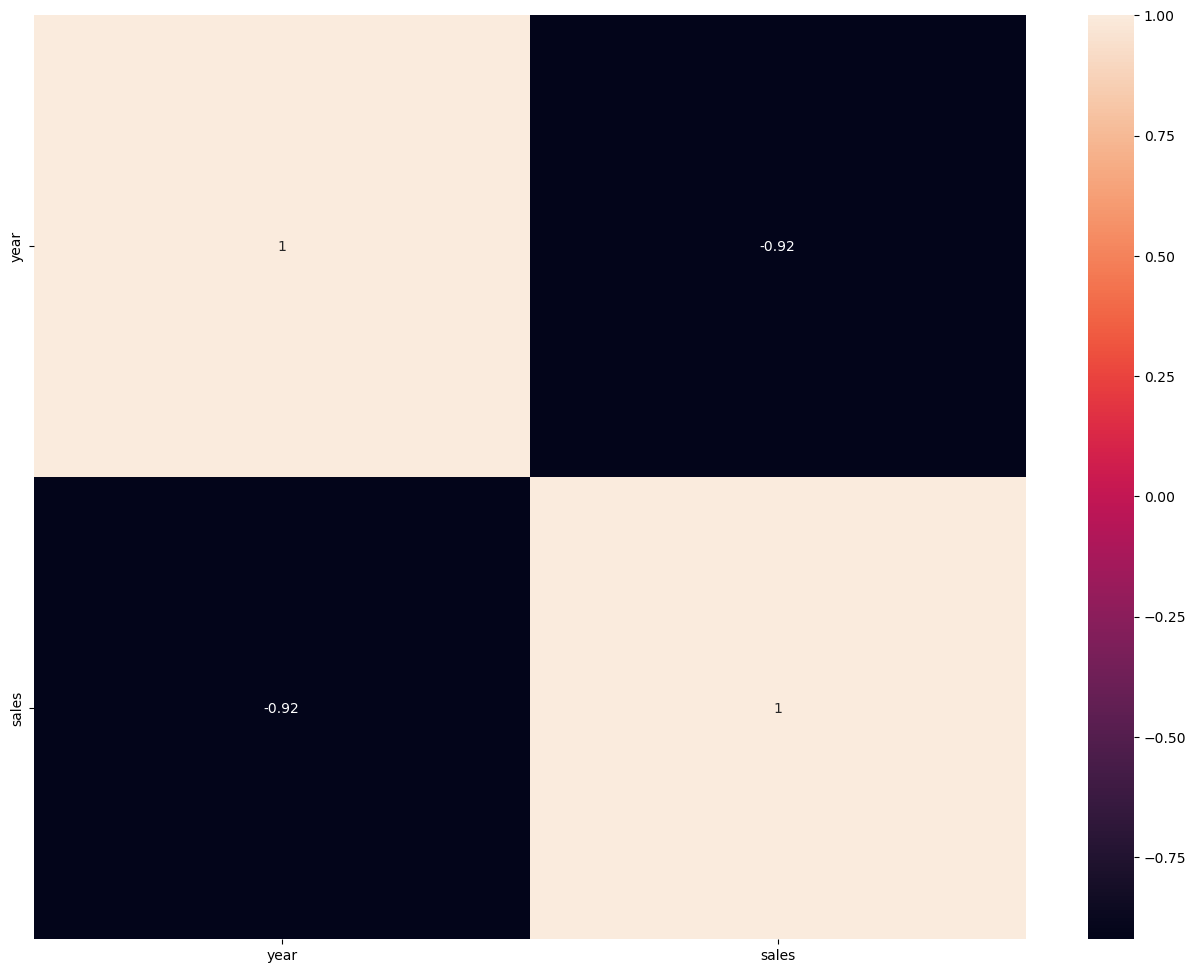

In [895]:
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### H10: Stores should sell more in the second half of the year.

False. Analyzing the graphs, we can see that stores sell less in the second half of the year. In other words, Rossmann's sales fall considerably in the second half of the year, indicating that this company concentrates its main profits at the beginning of the semester.

<Axes: xlabel='month', ylabel='sales'>

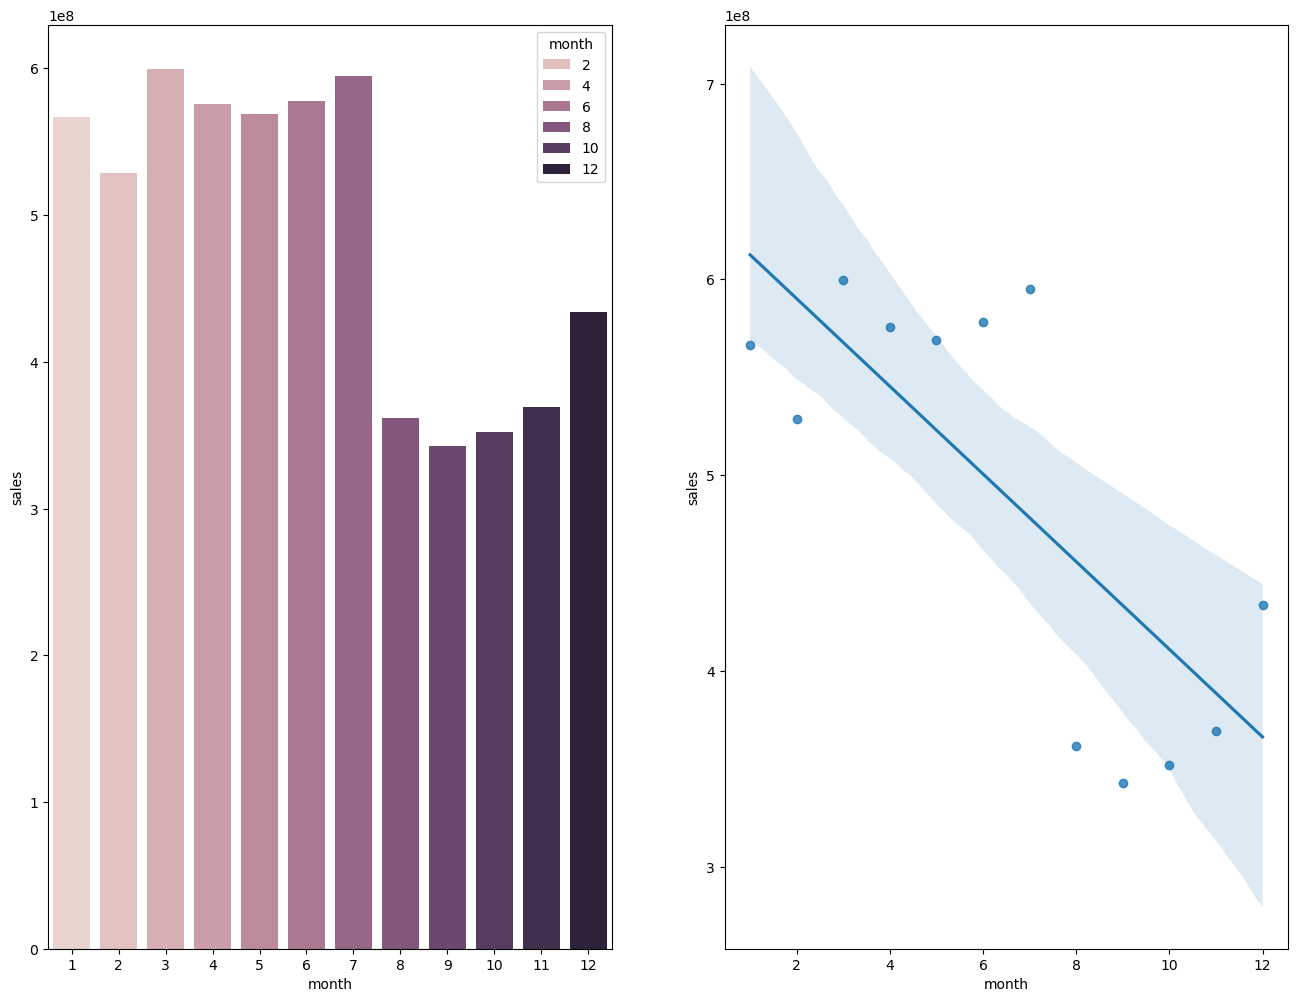

In [898]:

aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 2, 1)
sns.barplot( x='month', y='sales', data=aux1, hue='month')

plt.subplot( 1, 2, 2)
sns.regplot( x='month', y='sales', data=aux1 )

To infer the correlation of the feature with the response variable, a heatmap was used. In it, it can be seen that this variable alone has a very strong negative correlation with sales.

<Axes: >

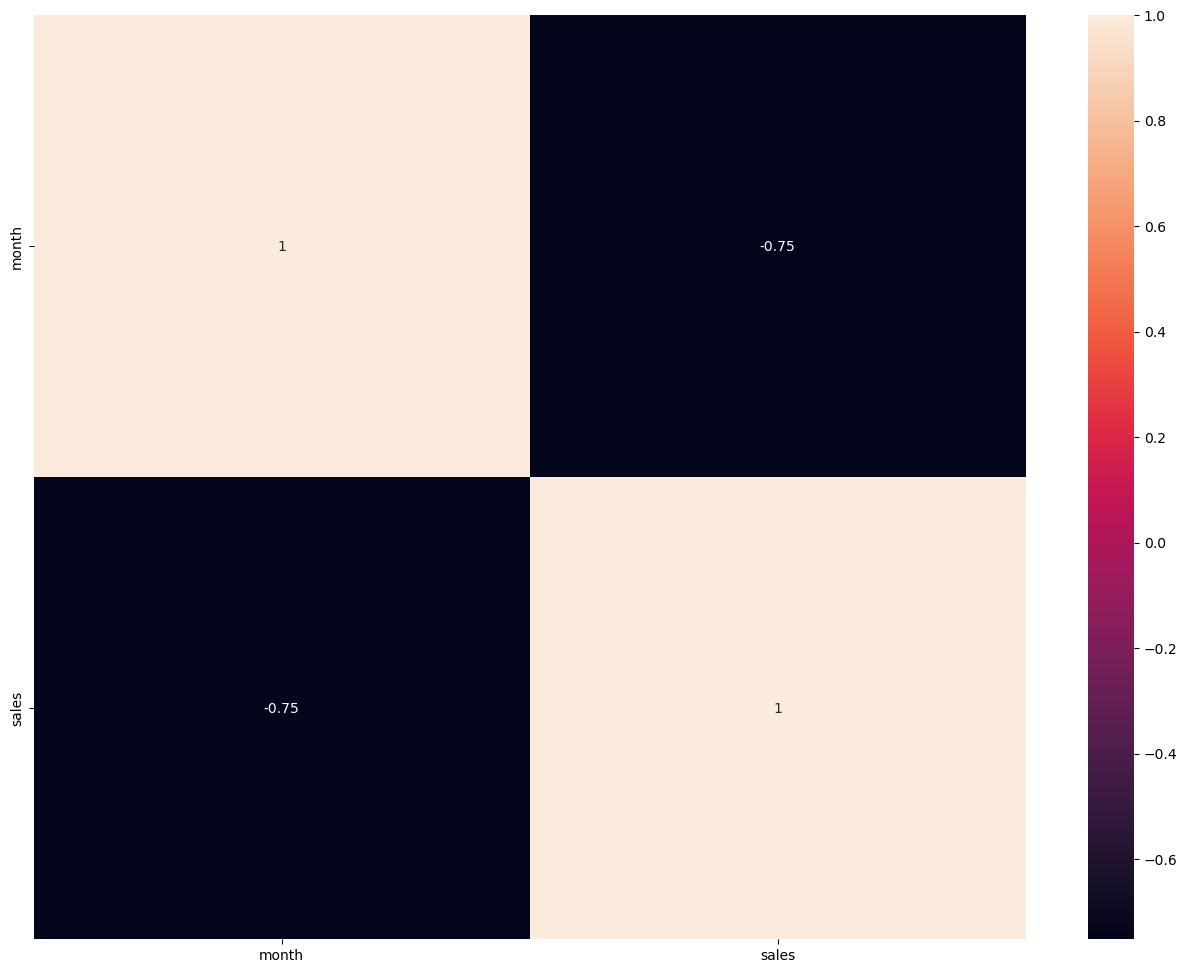

In [901]:
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### H11: Stores should sell more after the 10th of each month.

TRUE. Analyzing the graphs below, you can see that stores make more sales after the 10th of each month.

To infer the correlation of the feature with the response variable, a heatmap was used. In which, it is clear that this variable alone has a reasonable negative correlation with sales.

<Axes: >

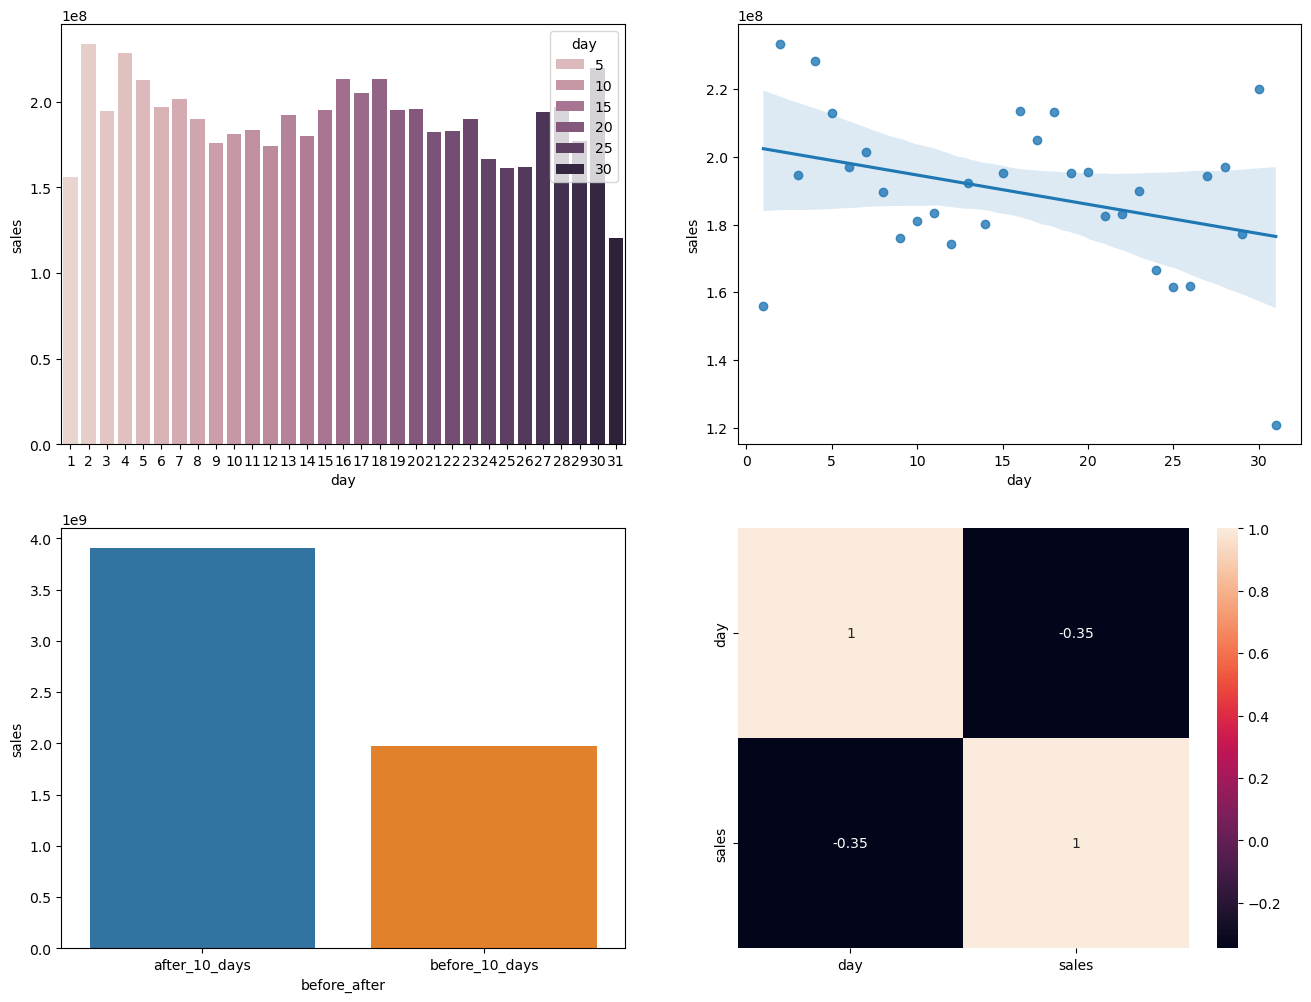

In [906]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1, hue='day')

plt.subplot( 2, 2, 2)
sns.regplot( x='day', y='sales', data=aux1 )

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 3)
sns.barplot( x='before_after', y='sales', data=aux2, hue='before_after')

plt.subplot( 2, 2, 4)
sns.heatmap( aux1[['day','sales']].corr( method='pearson' ), annot=True )

### H12: Stores should sell less during school holidays.

True. Analyzing the graphs below, it can be seen that stores sell less during school holidays, except in the month of August, where sales exceeded those of the normal period. It is also possible to see that in the months of July and August there was a sudden increase in sales. One theory behind this finding could be that during these months students are on school holidays, spending much more time away from school, consequently opening up more opportunities for them to shop in stores.

<Axes: xlabel='month', ylabel='sales'>

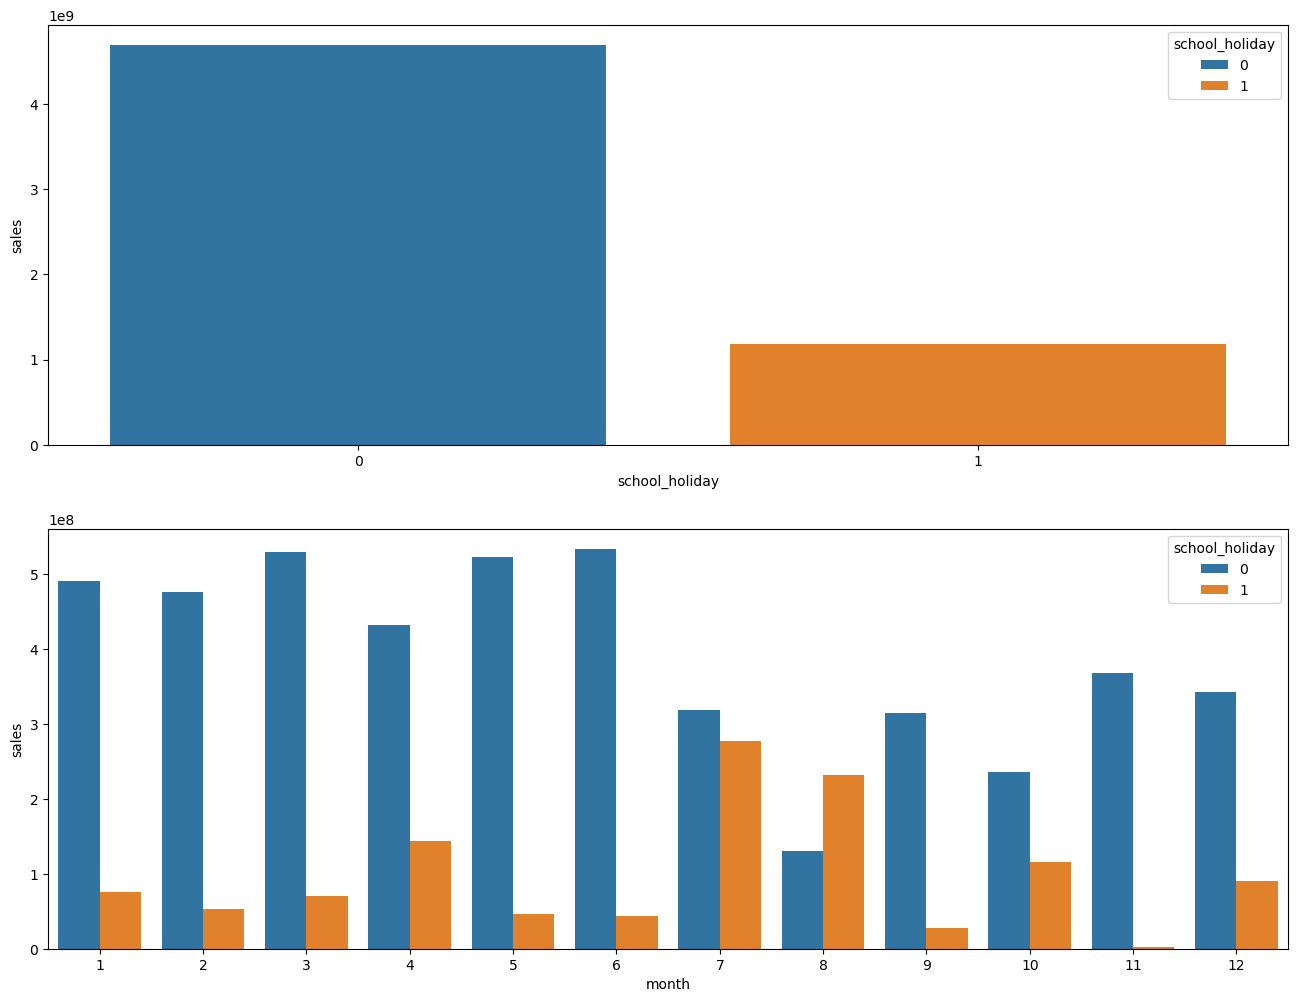

In [909]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot( x='school_holiday', y='sales', data=aux1, hue='school_holiday' )

plt.subplot(2, 1, 2)
aux2 = df4[['month','school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 )

# Hypothesis Final

In [931]:
tab = [ ['Hypotheses', 'Conclusion', 'Relevance' ],
['H1', 'False', 'Low'],
['H2', 'False', 'Medium'],
['H3', 'False', 'Medium'],
['H4', 'False', 'Low'],
['H5', 'False', 'Low'],
['H6', 'False', 'Low'],
['H7', 'False', 'Medium'],
['H8', 'True', 'High'],
['H9', 'False', 'High'],
['H10', 'False', 'High'],
['H11', 'True', 'High'],
['H12', 'True', 'Low'], ]
print( tabulate( tab, headers='firstrow' ) )

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            False         Low
H6            False         Low
H7            False         Medium
H8            True          High
H9            False         High
H10           False         High
H11           True          High
H12           True          Low


# Multivariate Analysis

## Numerical Attributes

<Axes: >

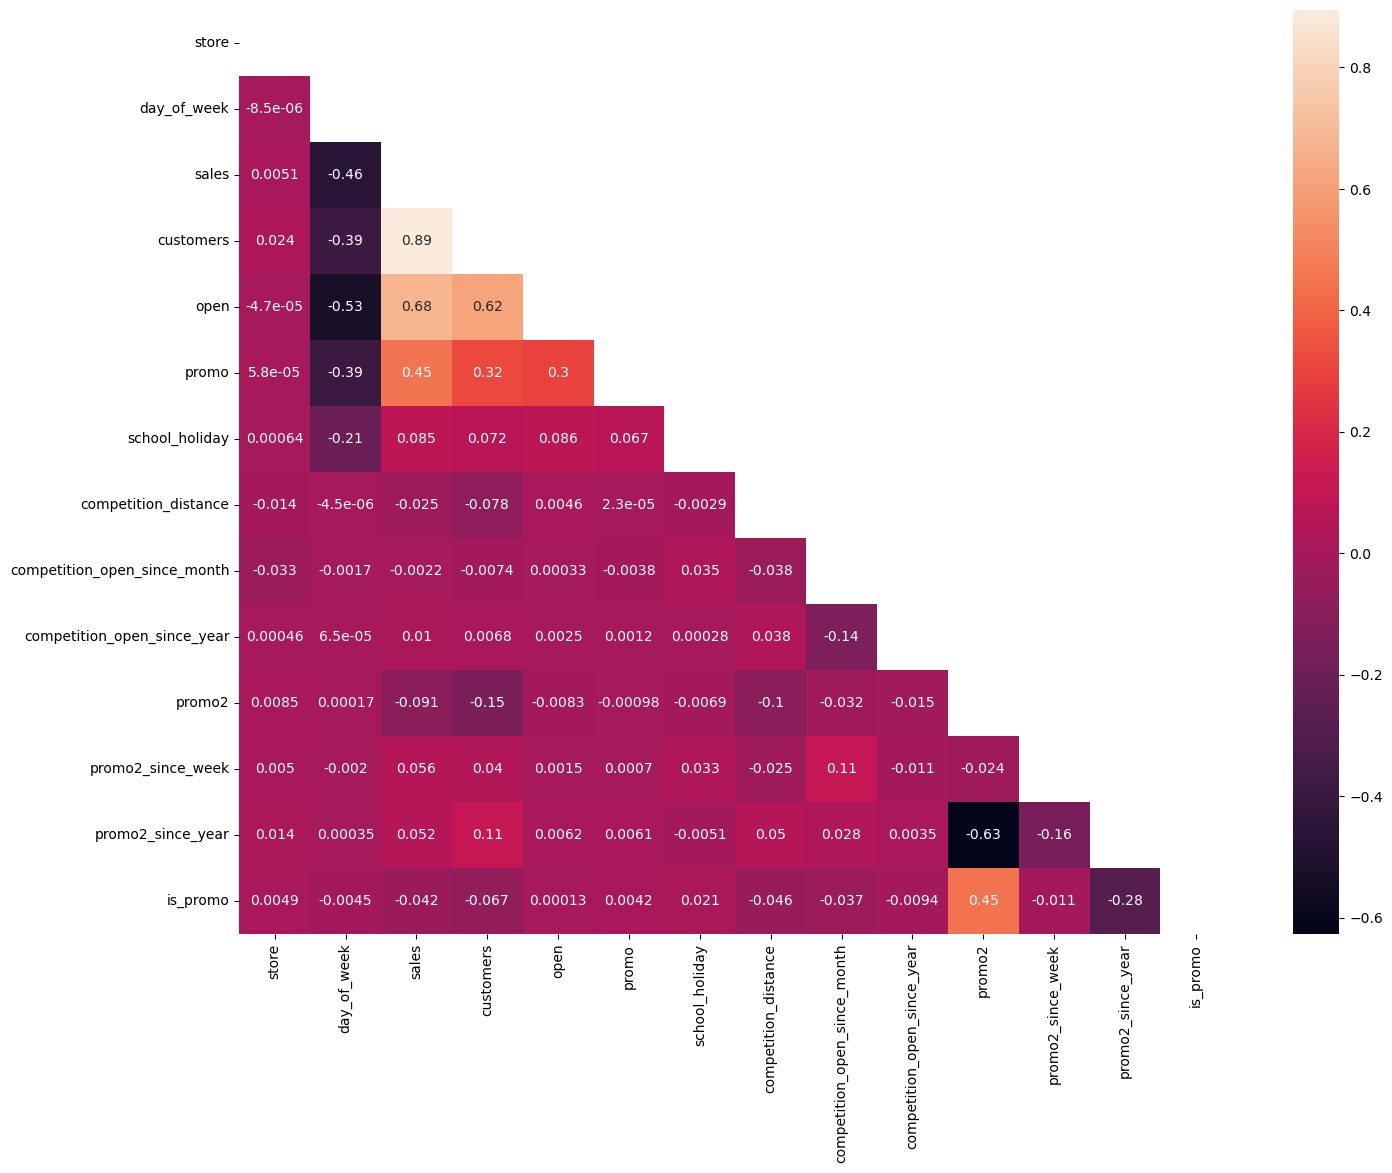

In [935]:
correlation = num_attributes.corr( method='pearson' )

# generate a mask for the upper triangle
mask = np.triu( np.ones_like(correlation, dtype=bool) )

sns.heatmap( correlation, annot=True, mask=mask )

## Categorical Attributes

In [946]:
def category_stats( x, y ):
    
    cm = pd.crosstab( x, y ).to_numpy()
    
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - ( k-1 ) * ( r-1 ) / ( n-1 ) )
    
    kcorr = k - ( k-1 )**2 / ( n-1 )
    rcorr = r - ( r-1 )**2 / ( n-1 )
    

    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ) )


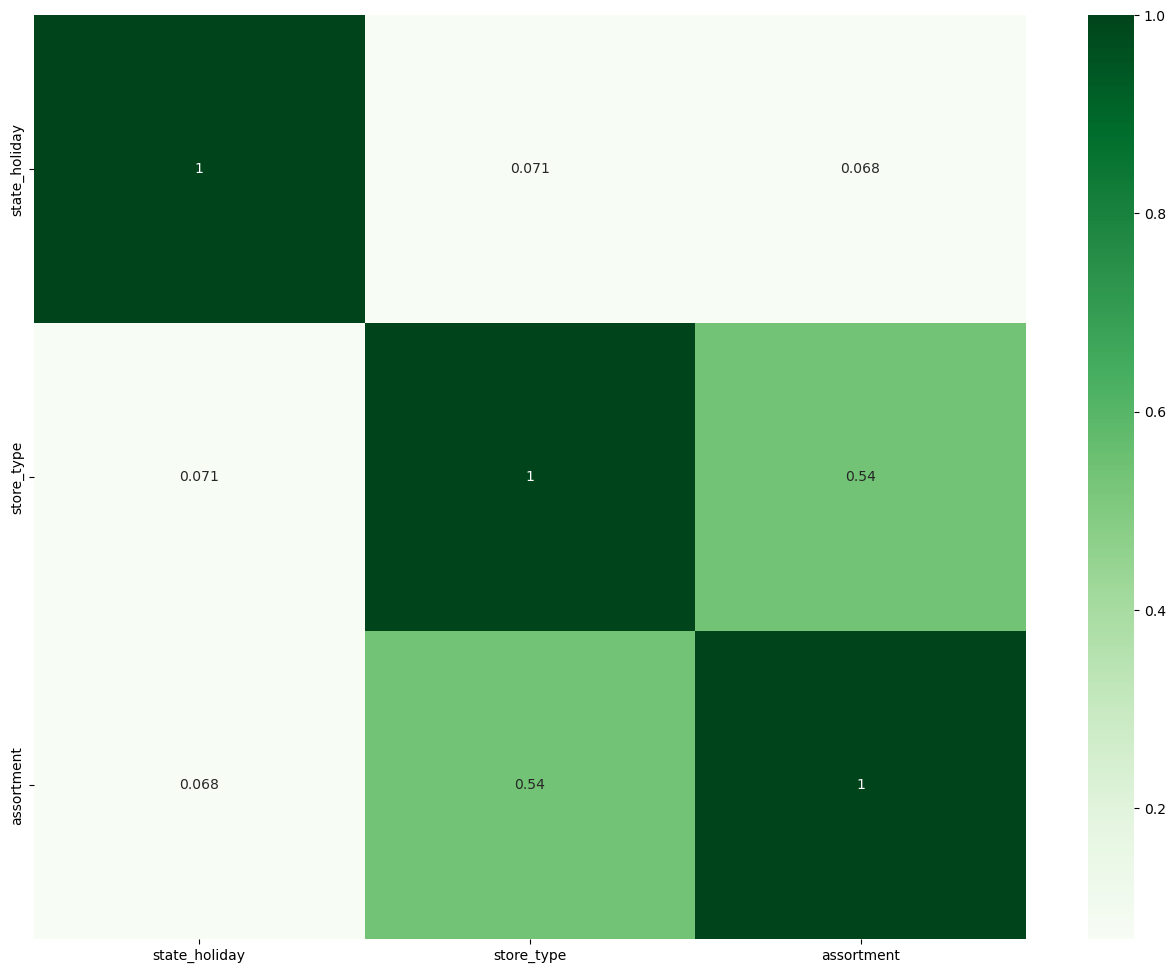

In [948]:

# only categorical data
new_catg = df4.select_dtypes( include='object' )

# calculate cramer V
catg1 = category_stats(new_catg['state_holiday'], new_catg['state_holiday'])
catg2 = category_stats(new_catg['state_holiday'], new_catg['store_type'])
catg3 = category_stats(new_catg['state_holiday'], new_catg['assortment'])

catg4 = category_stats(new_catg['store_type'], new_catg['state_holiday'])
catg5 = category_stats(new_catg['store_type'], new_catg['store_type'])
catg6 = category_stats(new_catg['store_type'], new_catg['assortment'])

catg7 = category_stats(new_catg['assortment'], new_catg['state_holiday'])
catg8 = category_stats(new_catg['assortment'], new_catg['store_type'])
catg9 = category_stats(new_catg['assortment'], new_catg['assortment'])

# Category attributes matrix
catg_matrix = pd.DataFrame( {
                                'state_holiday': [catg1, catg2, catg3],
                                'store_type': [catg4, catg5, catg6],
                                'assortment': [catg7, catg8, catg9],              
                            })

catg_matrix = catg_matrix.set_index( catg_matrix.columns )
sns.heatmap( catg_matrix, annot=True, cmap='Greens' );

# Data Preparation

In [951]:
df5 = df4.copy()

## Rescaling

To identify which transformation method to use, a boxplot of the variables below was plotted to verify which would be the best transformation method to use. Analyzing the graphs below, it was noted that for the features competition_distance and competition_time_month, the most suitable method would be the Robust Scaler, due to their high number of outliers. For the features year and promo_time_week, the transformation method would be the Min Max Scaler, as they do not have as many outliers.

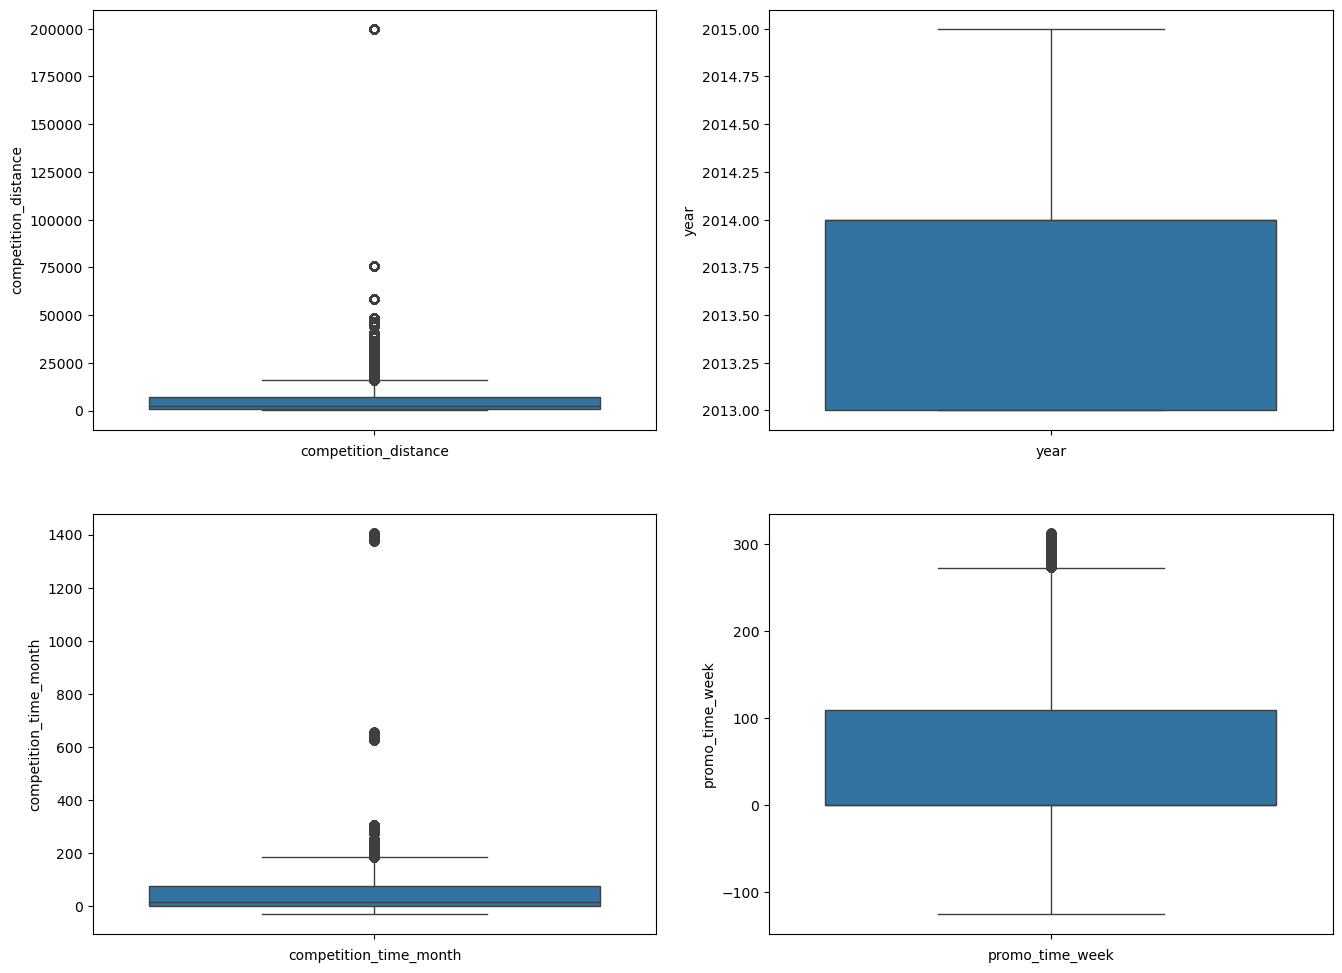

In [955]:
plt.subplot(2, 2, 1)
sns.boxplot( data=df5['competition_distance'] );
plt.xlabel('competition_distance');

plt.subplot(2, 2, 2)
sns.boxplot( data=df5['year'] );
plt.xlabel('year');

plt.subplot(2, 2, 3)
sns.boxplot( data=df5['competition_time_month'] );
plt.xlabel('competition_time_month');

plt.subplot(2, 2, 4)
sns.boxplot( data=df5['promo_time_week'] );
plt.xlabel('promo_time_week');


In [967]:
# applying transformations
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( '/Users/savitharachuri/Desktop/rossmann-store-sales/encoding_competition_distance_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( '/Users/savitharachuri/Desktop/rossmann-store-sales/encoding_year_scaler.pkl', 'wb' ) )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( '/Users/savitharachuri/Desktop/rossmann-store-sales/encoding_competition_time_month_scaler.pkl', 'wb' ) )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( '/Users/savitharachuri/Desktop/rossmann-store-sales/encoding_promo_time_week_scaler.pkl', 'wb' ) )


# Transformation

## Encoding

In this step,apply transformations that make sense for each feature.

In [973]:

# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( '/Users/savitharachuri/Desktop/rossmann-store-sales/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

## Response Variable Transformation

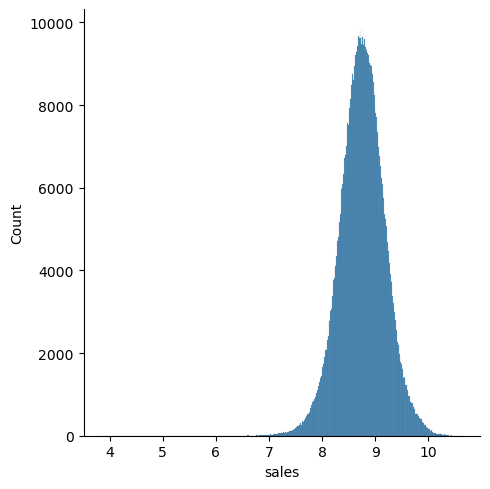

In [976]:
df5['sales'] = np.log1p( df5['sales'] )
sns.displot( df5['sales'] );

## Nature Transformation

This step is very important to maintain the cyclical nature of the periods of the years, such as day, month, day of the week, week of the year, etc. Although this step results in adding more columns to the dataset, consequently increasing its dimensionality, this generates a gain when training the machine learning algorithm, which will be able to understand this phenomenon with much more clarity and precision.

In [980]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi /7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi /7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi /12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi /12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi /30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi /30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi /52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi /52 ) ) )


# Feature Selection

In [983]:
df6 = df5.copy()

## Split Data Frame Into Training and Test

In [986]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

Identifying training and testing dates. In which, the last 6 weeks will be the testing data and the training data will be the entire dataset up to the cutoff date discovered by the code below.

In [991]:
df6[['date', 'store']].groupby( 'store' ).max().reset_index()['date'][0] - timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [993]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format( X_train['date'].min() ) )
print('Training max date: {}'.format( X_train['date'].max() ) )

print('\nTest min date: {}'.format( X_test['date'].min() ) )
print('Test max date: {}'.format( X_test['date'].max() ) )

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## Manual Features Selection

In [996]:
cols_selected = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_full = cols_selected.copy()
cols_selected_full.extend( feat_to_add )

# Machine Learning Modelling

In [999]:
x_train = X_train[cols_selected]
x_test = X_test[cols_selected]

# Time Series data preparation
x_training = X_train[cols_selected_full]

## Average Model

In [1020]:
def ml_error( model_name, y_pred, yhat ):
    mae = mean_absolute_error( y_pred, yhat )
    mape = mean_absolute_percentage_error( y_pred, yhat )
    rmse = np.sqrt( mean_squared_error( y_pred, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0] )

In [1022]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()


# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result



,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


# Linear Regression Model

In [1025]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction 
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## Linear Regression Model - Cross Validation

In [1028]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):

  mae_list = []
  mape_list = []
  rmse_list = []

  for k in reversed( range(1, kfold+1 ) ):

    if verbose:
      print( f'\nKFold Number: {k}' )

    # start and end date for validation 
    validation_start_date = x_training[ 'date' ].max() - timedelta( days=k*6*7 )
    validation_end_date = x_training[ 'date' ].max() - timedelta( days=(k-1)*6*7 )

    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

    # training and validation dataset
    # training
    xtraining = training.drop( ['date', 'sales'], axis=1 )
    ytraining = training['sales']

    # validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']

    # model
    m = model.fit( xtraining, ytraining )

    # prediction
    yhat = m.predict( xvalidation )

    # performance
    model_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

    # store performance of each kfold iteration
    mae_list.append(  model_result['MAE']  )
    mape_list.append( model_result['MAPE'] )
    rmse_list.append( model_result['RMSE'] )

  return pd.DataFrame(  { 'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [1030]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


# Linear Regression Regularized Model

In [1035]:
# model
lrr = Lasso(alpha=0.01).fit(x_train,y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error( 'Linear Regression Regularized - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized - Lasso,1891.704881,0.289106,2744.451737


## Linear Regression Regularized Model - Cross Validation

In [1038]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


Analyzing the performance of linear behavior models, it was noticed that they performed worse than a simple average model (Average Model). Analyzing this fact, it gives us confirmation that the phenomenon that the model is trying to learn has non-linear behavior. Therefore, in the next step, non-linear algorithms will be used so that the model can learn and improve its performance.

# Random Forest Regressor

In [1044]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=9 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,686.575274,0.101017,1024.133545


## Random Forest Regressor - Cross validation

In [1047]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.12 +/- 214.35,0.12 +/- 0.02,1254.79 +/- 314.84


# XGBoost Regressor

In [1071]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=100, eta=0.01, 
                             max_depth=10, subsample=0.7, colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:53:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1695.785983,0.251783,2478.398037


## XGBoost Regressor - Cross Validation 

In [1073]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:53:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 4


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 3


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:54:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 2


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:54:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 1


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1860.64 +/- 291.01,0.25 +/- 0.01,2685.39 +/- 429.0


# Compare Models Performance

## Single Performance

In [1075]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,686.575274,0.101017,1024.133545
0,Average Model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1695.785983,0.251783,2478.398037
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression Regularized - Lasso,1891.704881,0.289106,2744.451737


## Real Performance - Cross Validation

In [1078]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.12 +/- 214.35,0.12 +/- 0.02,1254.79 +/- 314.84
0,XGBoost Regressor,1860.64 +/- 291.01,0.25 +/- 0.01,2685.39 +/- 429.0
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


Analyzing the performance of the non-linear algorithms, it was noticed that the 2 algorithms that presented the best results were Random Forest Regressor and XGBoost Regressor, both presented a very similar RMSE (Root Mean Squared Error) and much lower than the linear algorithms, therefore, it is up to me as a data scientist to choose which model will be used in production. Analyzing the issue of the time it took for the Random Forest Regressor to be trained, and the possible financial cost that this algorithm can bring to be implemented, considering that the difference between it and the XGBoost Regressor is not so considerable in relation to the other models, I decided to choose XGBoost as the ideal algorithm to put the model into production and make the necessary parameter adjustments to improve its performance.

# Hyperparameter Fine Tuning

## Random Search

In [1086]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytee': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

## Final Model

In [1091]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytee': 0.7,
    'min_child_weight': 3 
}

In [1093]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=param_tuned['n_estimators'], eta=param_tuned['eta'], max_depth=param_tuned['max_depth'], 
                             subsample=param_tuned['subsample'], colsample_bytee=param_tuned['colsample_bytee'], min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,769.902807,0.115168,1115.278073


In [1095]:
# saving trained model
pickle.dump(  model_xgb_tuned, open( '/Users/savitharachuri/Desktop/rossmann-store-sales/rossmann_xgb_model.pkl', 'wb' ) )

# Error Interpretation and Translation

In [1100]:
df9 = X_test[ cols_selected_full ]

# rescaling
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

/var/folders/39/rg_25byj0td2vdcz116kf6wr0000gn/T/ipykernel_27069/3857877242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
/var/folders/39/rg_25byj0td2vdcz116kf6wr0000gn/T/ipykernel_27069/3857877242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## Business Performance

In [1133]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE and RMSE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

/var/folders/39/rg_25byj0td2vdcz116kf6wr0000gn/T/ipykernel_27069/1289641449.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
/var/folders/39/rg_25byj0td2vdcz116kf6wr0000gn/T/ipykernel_27069/1289641449.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

In [1135]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
721,722,348243.250000,346379.220466,350107.279534,1864.029534,0.244588
899,900,246730.437500,246010.937130,247449.937870,719.500370,0.111457
528,529,295201.406250,294665.273213,295737.539287,536.133037,0.061956
651,652,252151.234375,251664.853687,252637.615063,486.380688,0.077319
918,919,208028.531250,207520.008486,208537.054014,508.522764,0.092659


To identify which stores have the greatest difficulty in achieving an adequate sales forecast, an order is made by MAPE (Mean Absolute Percentage Error), which indicates the variation in terms of the MAE (Mean Absolute Error) percentage. Analyzing the table below, it can be seen that store: 292 has a MAPE of 60%, that is, the predicted value on average may be 60% above or below (overestimating or underestimating).

In [1110]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107308.632812,103931.709473,110685.556152,3376.923340,0.604157
908,909,218559.093750,210519.178244,226599.009256,8039.915506,0.526616
594,595,303071.281250,296959.342787,309183.219713,6111.938463,0.422214
268,269,372361.750000,370050.540686,374672.959314,2311.209314,0.333740
875,876,194526.062500,190484.746264,198567.378736,4041.316236,0.317061


<Axes: xlabel='store', ylabel='MAPE'>

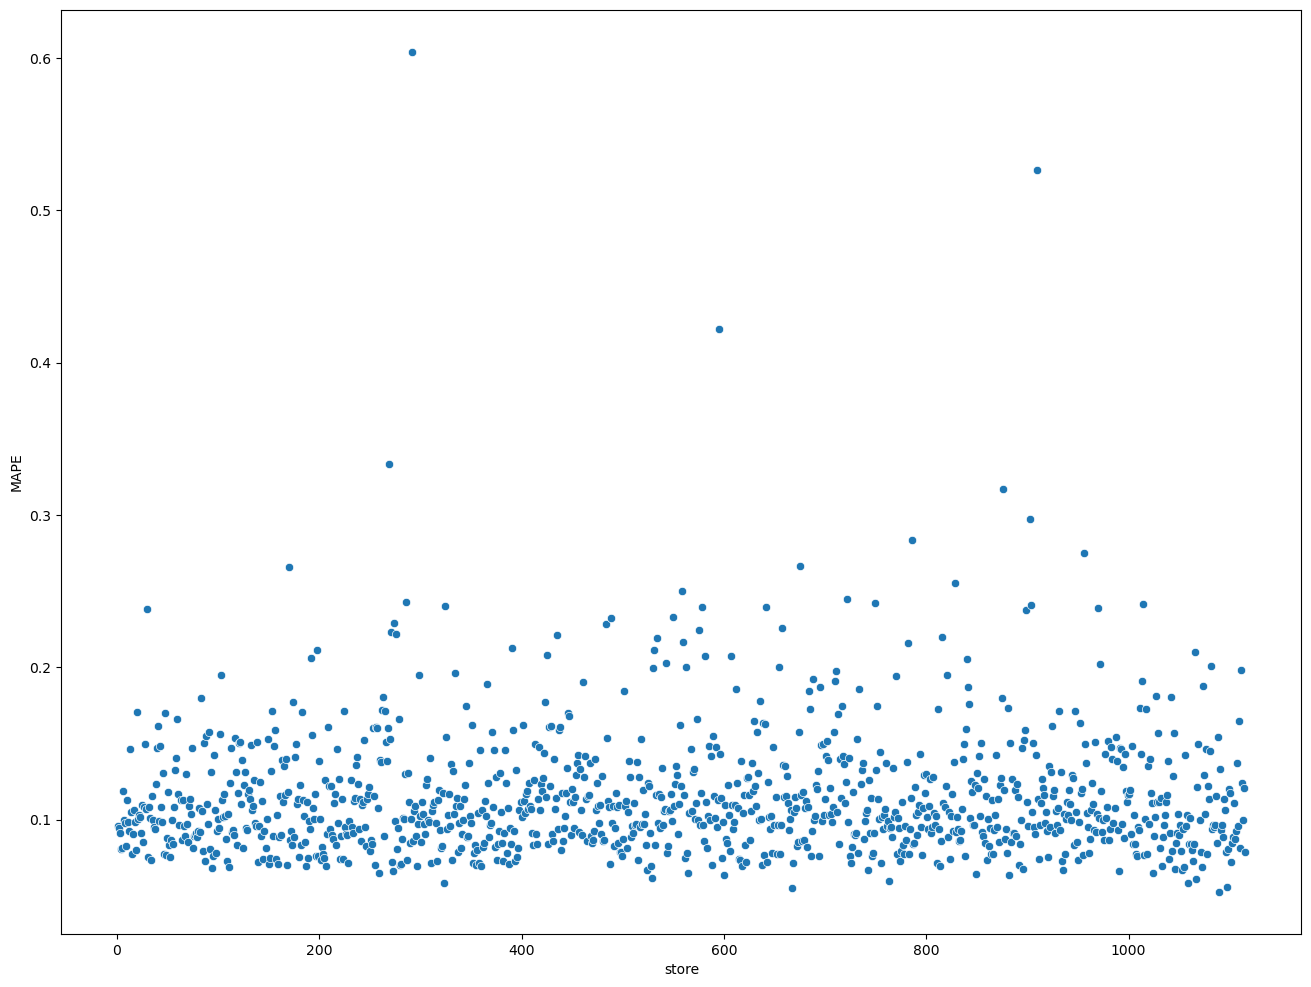

In [1113]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## Total Performance

The table below shows the CFO (stakeholder) what the risk and forecast for Rossmann stores are. It is noteworthy that the difference between the best and worst case scenarios is not very high, approximately 1.5 million, considering that on average, the values ​​of the best and worst case scenarios are in the range of 285.9 million.

In [1117]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'scenario', 0: 'values'} )
df93['values'] = df93['values'].map( '${:,.2f}'.format )
df93

,scenario,values
0,predictions,"$287,038,848.00"
1,worst_scenario,"$286,177,230.34"
2,best_scenario,"$287,900,483.24"


## Machine Learning Performance

In [1120]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/var/folders/39/rg_25byj0td2vdcz116kf6wr0000gn/T/ipykernel_27069/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/var/folders/39/rg_25byj0td2vdcz116kf6wr0000gn/T/ipykernel_27069/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


/var/folders/39/rg_25byj0td2vdcz116kf6wr0000gn/T/ipykernel_27069/2201254292.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df9['error'] )


<Axes: xlabel='predictions', ylabel='error'>

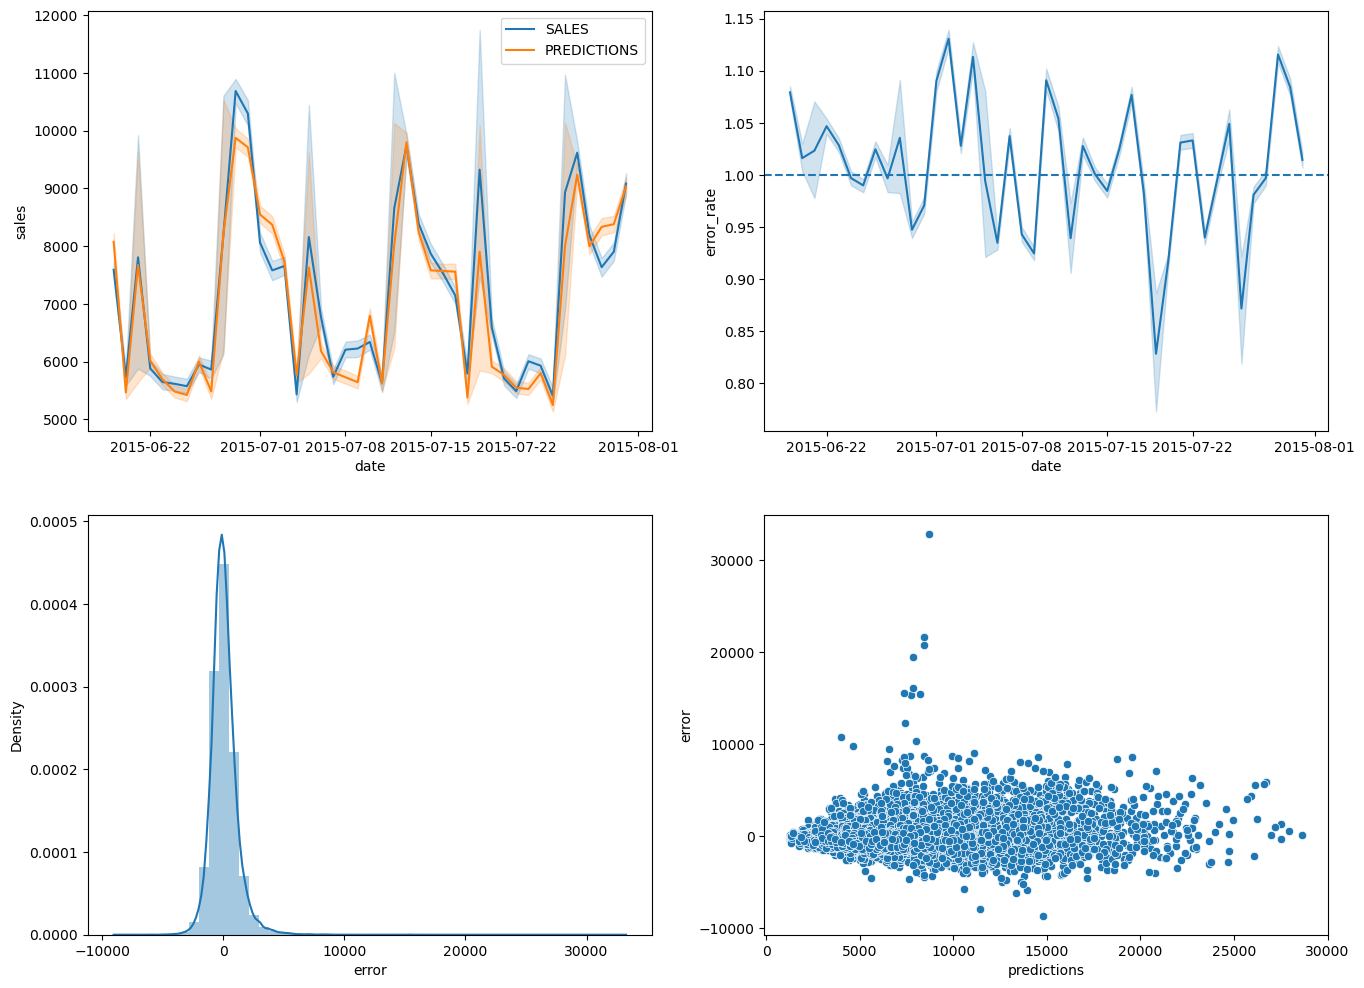

In [1124]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3)
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4)
sns.scatterplot( x=df9['predictions'], y=df9['error'] )

Analyzing the graphs above that aim to show how the machine learning model trained in this stage of the project is performing, it is clear that XGBoost presented excellent performance results in the first CRISP cycle, in which a good approximation of the real sales values. Although it is still in the first stage of the cycle, this model can already be used as a solution to the sales forecasting problem, given that it is already capable of predicting sales in most stores with great precision.